# Modélisation – Prédiction de l'attrition

## 1. Contexte & objectifs

Ce notebook constitue la phase de modélisation du projet de prédiction de l'attrition. À partir des données nettoyées et enrichies lors de l'analyse exploratoire (1_notebook), l'objectif est de construire un modèle de classification binaire capable d'identifier les employés à risque de départ, afin de permettre aux équipes RH de mettre en place des actions préventives.

**Déséquilibre des classes** : seuls ~16 % des employés quittent l'entreprise, ce qui impose une stratégie de modélisation adaptée.

**Asymétrie des coûts** : un départ non détecté (faux négatif) coûte significativement plus cher qu'une fausse alerte (faux positif), qui se traduit par un simple entretien préventif.

**Stratégie** : nous procéderons par étapes — modèles baseline, gestion du déséquilibre, optimisation, puis interprétation

### Setup du notebook et chargement des données

In [ ]:
import pandas as pd
import preprocessing as pp
import modelization as md
import visualizer as vi
import matplotlib.pyplot as plt

#Selection
from sklearn.model_selection import (
	train_test_split,
	StratifiedKFold
)
#Modèles
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline  # Pipeline compatible imblearn
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.base import clone

from sklearn.metrics import (
	make_scorer, recall_score, precision_score, f1_score,
	classification_report, confusion_matrix, average_precision_score
)

df = pd.read_csv("data/data_clean.csv")

TARGET = 'a_quitte_l_entreprise'
TEST_SIZE = 0.2
RANDOM_STATE = 42
N_SPLIT = 5
CLASS_NAMES = ['Reste', 'Quitte']

X, y, preprocessor = pp.prepare_ml_data(
    df,
    target=TARGET,
    binary_ordinal_features=[
        'genre',
        'frequence_deplacement',
        'flag_surcharge_et_deplacement',
        'surcharge_travail',
        'note_evaluation_actuelle',
    ]
)

## 2. Préparation des données

### Inspection des données d'entrée

Avant de modéliser, vérifions la structure des données préparées lors de l'analyse exploratoire : dimensions de X et y, types de features détectés par le preprocessor, et aperçu des premières lignes.


In [2]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'str']).columns.tolist()

print(f"Dimensions : X = {X.shape}, y = {y.shape}")
print(f"\nFeatures numériques ({len(numeric_features)}) : {numeric_features}")
print(f"\nFeatures catégorielles ({len(categorical_features)}) : {categorical_features}")
print(f"\nDistribution de la cible :")
print(y.value_counts().rename(index={0: 'Reste', 1: 'Quitte'}))

display(X.head())

Dimensions : X = (1470, 28), y = (1470,)

Features numériques (25) : ['age', 'genre', 'nombre_experiences_precedentes', 'annee_experience_totale', 'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel', 'satisfaction_employee_environnement', 'note_evaluation_precedente', 'satisfaction_employee_nature_travail', 'satisfaction_employee_equipe', 'satisfaction_employee_equilibre_pro_perso', 'note_evaluation_actuelle', 'augmentation_salaire_precedente', 'nombre_participation_pee', 'nb_formations_suivies', 'distance_domicile_travail', 'niveau_education', 'frequence_deplacement', 'stabilite_management', 'surcharge_travail', 'flag_surcharge_et_deplacement', 'ratio_promotion_anciennete', 'satisfaction_globale', 'satisfaction_min', 'log_revenu']

Features catégorielles (3) : ['statut_marital', 'poste', 'domaine_etude']

Distribution de la cible :
a_quitte_l_entreprise
Reste     1233
Quitte     237
Name: count, dtype: int64


,age,genre,statut_marital,poste,nombre_experiences_precedentes,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel,satisfaction_employee_environnement,note_evaluation_precedente,...,niveau_education,domaine_etude,frequence_deplacement,stabilite_management,surcharge_travail,flag_surcharge_et_deplacement,ratio_promotion_anciennete,satisfaction_globale,satisfaction_min,log_revenu
0,41,0,Célibataire,Cadre Commercial,8,8,6,4,2,3,...,2,Infra & Cloud,1,1.000000,2,0,0.000000,8,1,8.698514
1,49,1,Marié(e),Assistant de Direction,1,10,10,7,3,2,...,1,Infra & Cloud,2,0.875000,0,0,0.090909,12,2,8.543056
2,37,1,Célibataire,Consultant,6,7,0,0,4,2,...,2,Autre,1,0.000000,2,0,0.000000,12,2,7.645398
3,33,0,Marié(e),Assistant de Direction,1,8,8,7,4,3,...,4,Infra & Cloud,2,0.000000,3,1,0.333333,13,3,7.975908
4,27,1,Marié(e),Consultant,9,6,2,2,1,3,...,1,Transformation Digitale,1,0.666667,0,0,0.666667,10,1,8.151622


### Séparation train/test

Le découpage train/test est réalisé avec l’option `stratify=y` afin de préserver la distribution des classes dans les deux ensembles, ce qui est essentiel compte tenu du fort déséquilibre du jeu de données, et permet d’obtenir une évaluation plus représentative des performances du modèle.

Nous réservons 20% des données comme jeu de test pour l'évaluation finale des modèles, et nous appliquerons une validation croisée sur le jeu de train.

In [3]:
X_train_test, X_val, y_train_test, y_val = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
	stratify=y
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train_test,
    y_train_test,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
	stratify=y_train_test
)

### Distribution des classes

Avant d'entraîner nos modèles, quantifions le déséquilibre entre les classes. Ce ratio conditionne directement la stratégie de modélisation et le choix des métriques, car un modèle naïf pourrait obtenir une accuracy élevée en prédisant systématiquement la classe majoritaire

Distribution globale :
a_quitte_l_entreprise
Reste     1233
Quitte     237
Name: count, dtype: int64

Proportion :
a_quitte_l_entreprise
Reste     83.9%
Quitte    16.1%
Name: proportion, dtype: str

Ratio déséquilibre : 1 Quitte pour 5.2 Reste


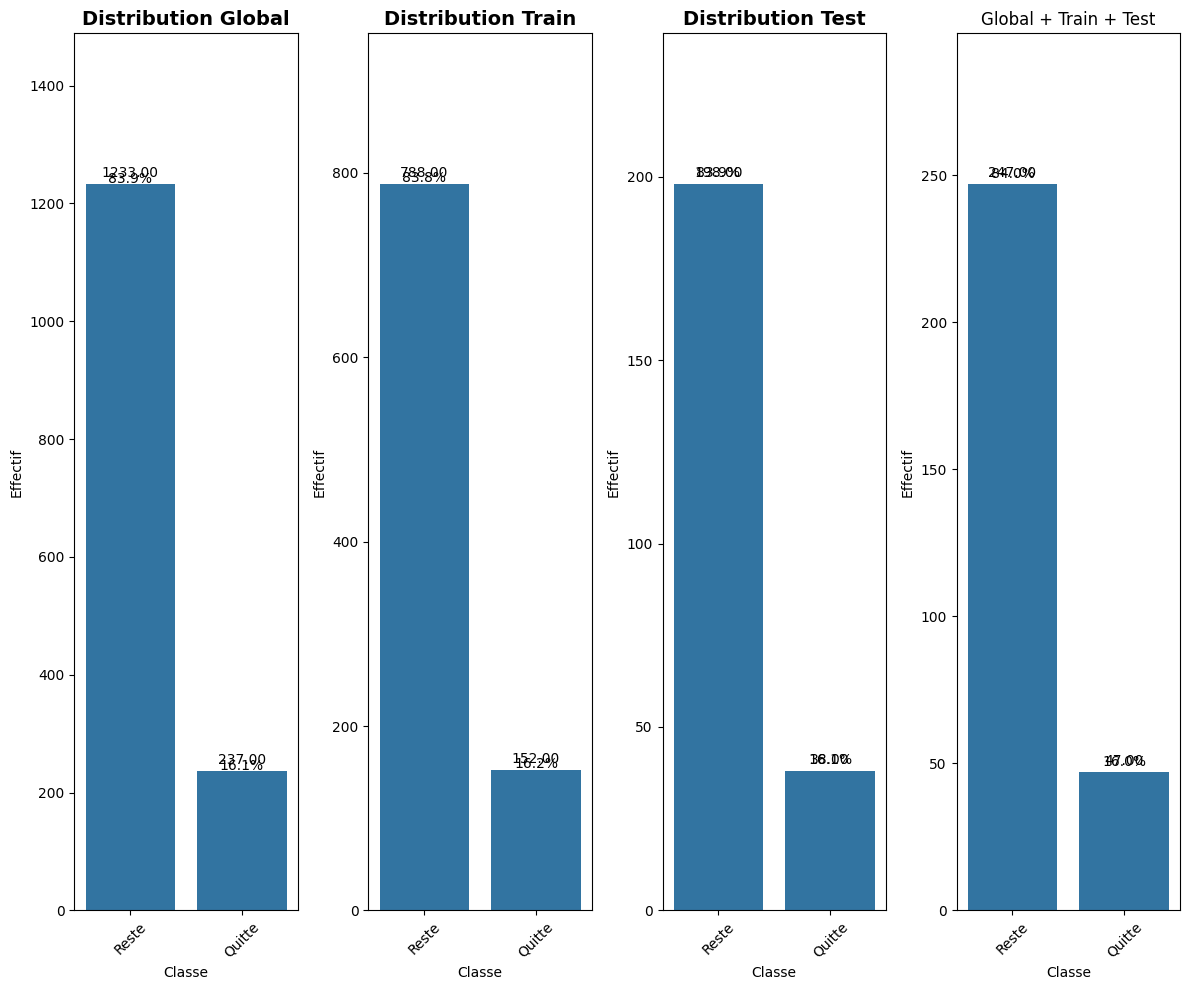

In [4]:
class_labels = {0: 'Reste', 1: 'Quitte'}

print("Distribution globale :")
print(y.value_counts().rename(index=class_labels))
print(f"\nProportion :")
print(y.value_counts(normalize=True).rename(index=class_labels).map(lambda x: f"{x:.1%}"))
print(f"\nRatio déséquilibre : 1 Quitte pour {y.value_counts()[0] / y.value_counts()[1]:.1f} Reste")

fig, axes = plt.subplots(1, 4, figsize=(12, 10))

for ax, (data, title) in zip(axes, [
    (y, "Global"), (y_train, "Train"), (y_test, "Test"), (y_val, "Val")
]):
    counts = data.value_counts().rename(index=class_labels)
    df_counts = pd.DataFrame({'Classe': counts.index, 'Effectif': counts.values})
    vi.create_barplot(
        df_counts, ax, x='Classe', y='Effectif',
        title=f'Distribution {title}'
    )
    for i, (label, count) in enumerate(counts.items()):
        pct = count / len(data)
        ax.text(i, count + 2, f"{pct:.1%}", ha='center', fontsize=10)
plt.title("Global + Train + Test")
plt.tight_layout()
plt.show()

**Observation**

La distribution montre un fort déséquilibre entre les classes : 83,9% des employés restent dans l’entreprise contre seulement 16,1% qui la quittent (environ 1 départ pour 5 employés restants).



## 3. Modèles baseline

### Choix des modèles

L’objectif est de prédire si un employé va quitter l’entreprise : il s’agit donc d’un problème de **classification binaire**.

Pour comparer différentes approches, quatre modèles ont été évalués :

- **DummyClassifier**  
  Sert de baseline avec la stratégie `most_frequent`, qui prédit systématiquement la classe majoritaire.  
  Cela permet d’établir un niveau minimal de performance et de vérifier que les modèles entraînés apportent un réel gain.

- **LogisticRegression**  
  Modèle linéaire simple, rapide et interprétable, utilisé comme première approche supervisée.

- **RandomForestClassifier**  
  Modèle non linéaire basé sur un ensemble d’arbres de décision, capable de capturer des relations complexes entre les variables.

- **XGBClassifier**  
  Modèle de gradient boosting qui entraîne les arbres séquentiellement, chaque nouvel arbre corrigeant les erreurs du précédent.

In [ ]:
pipelines = {
    "Dummy": Pipeline([
        ('preprocessor', clone(preprocessor)),
        ('model', DummyClassifier(strategy="most_frequent"))
    ]),
	"LR_baseline": Pipeline([
        ('preprocessor', clone(preprocessor)),
        ('model', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000))
    ]),
    "RF_baseline": Pipeline([
        ('preprocessor', clone(preprocessor)),
        ('model', RandomForestClassifier(random_state=RANDOM_STATE))
    ]),
    "XGB_baseline": Pipeline([
        ('preprocessor', clone(preprocessor)),
        ('model', XGBClassifier(random_state=RANDOM_STATE))
    ])
}

### Choix de la métrique principale

#### 1. Contexte du problème

Le projet vise à prédire le départ potentiel des employés (**attrition**), un problème de classification binaire caractérisé par un **déséquilibre marqué des classes**, la majorité des employés restant dans l’entreprise.

Dans ce contexte, l’évaluation des modèles ne peut pas reposer sur une métrique unique et doit prendre en compte à la fois la performance statistique et l’impact métier.


#### 2. Métriques évaluées

Plusieurs métriques sont utilisées afin d’analyser les performances des modèles sous différents angles :

- **Accuracy**  
  Proportion totale de prédictions correctes.  
  → Peu informative en cas de déséquilibre des classes, car elle favorise la classe majoritaire.

- **Precision (classe "Quitte")**  
  Proportion d’employés effectivement partis parmi ceux prédits comme partants.  
  → Mesure la fiabilité des alertes générées par le modèle.

- **Recall (classe "Quitte")**  
  Proportion d’employés ayant quitté l’entreprise correctement identifiés par le modèle.  
  → Mesure la capacité du modèle à détecter les départs.

- **F1-score (classe "Quitte")**  
  Moyenne harmonique entre precision et recall.  
  → Permet d’évaluer le compromis entre détection des départs et limitation des fausses alertes.

- **ROC-AUC**  
  Mesure la capacité du modèle à classer un employé quittant l’entreprise avec un score de risque plus élevé qu’un employé restant, indépendamment du seuil de décision.  
  → Utile pour comparer le pouvoir de discrimination global des modèles, mais peut être optimiste en contexte fortement déséquilibré.

- **PR-AUC (Area Under the Precision–Recall Curve)**  
  Synthétise le compromis précision/rappel sur la classe minoritaire.  
  → Particulièrement adaptée aux jeux de données déséquilibrés et plus représentative de la performance réelle sur la classe "Quitte".

Dans les résultats présentés, la **precision**, le **recall** et le **F1-score** sont calculés exclusivement sur la classe **"Quitte"** (classe positive = 1).


#### 3. Justification du choix métier

L’objectif principal du modèle est d’**identifier le plus grand nombre possible d’employés susceptibles de quitter l’entreprise**, afin de permettre aux équipes RH de mettre en place des actions préventives (entretiens, mobilité interne, revalorisation).

##### Inadéquation de l’accuracy

Un modèle prédisant systématiquement la classe majoritaire ("Reste") pourrait obtenir une accuracy élevée tout en étant inutilisable d’un point de vue opérationnel, car il ne détecterait aucun départ.

##### Priorité au recall sur la classe "Quitte"

Les coûts associés aux erreurs de classification sont asymétriques :

- **Faux négatif** (départ non détecté)  
  → Perte non anticipée, coûts élevés (recrutement, formation, perte de compétences)

- **Faux positif** (fausse alerte)  
  → Coût limité (entretien ou action RH préventive)

Cette asymétrie justifie de **privilégier le recall** sur la classe "Quitte".

##### Rôle du F1-score et de la PR-AUC

Optimiser uniquement le recall conduirait à générer un nombre excessif de fausses alertes.  
Le **F1-score** et la **PR-AUC** permettent de s’assurer que le modèle maintient un équilibre acceptable entre la capacité de détection des départs et la précision des alertes générées.

#### 4. Métrique principale retenue

Au regard du déséquilibre des classes et des enjeux métier, la **PR-AUC** est retenue comme métrique principale de comparaison des modèles, tandis que le **recall sur la classe "Quitte"** est utilisé comme indicateur clé de performance opérationnelle.


In [6]:
cv = StratifiedKFold(n_splits=N_SPLIT, shuffle=True, random_state=RANDOM_STATE)

scoring = {
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0),
    'roc_auc': 'roc_auc',
    'average_precision': 'average_precision',
}

all_cv_results_baseline, all_eval_results_baseline, df_all_results_baseline = md.run_evaluation(
    pipelines, X_train, y_train, X_test, y_test, cv, scoring
)
display(df_all_results_baseline.round(2))

,cv_train_precision,cv_train_precision_std,cv_test_precision,cv_test_precision_std,cv_train_recall,cv_train_recall_std,cv_test_recall,cv_test_recall_std,cv_train_f1,cv_train_f1_std,...,cv_train_average_precision_std,cv_test_average_precision,cv_test_average_precision_std,cv_time_sec,test_accuracy,test_precision,test_recall,test_f1,test_pr_auc,test_roc_auc
model,,,,,,,,,,,,,,,,,,,,,
Dummy,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.16,0.00,1.80,0.84,0.00,0.00,0.00,0.16,0.50
LR_baseline,0.79,0.02,0.76,0.15,0.47,0.01,0.42,0.06,0.59,0.01,...,0.02,0.64,0.09,1.53,0.90,0.75,0.55,0.64,0.67,0.83
RF_baseline,1.00,0.00,0.76,0.14,1.00,0.00,0.18,0.07,1.00,0.00,...,0.00,0.52,0.05,1.56,0.86,0.67,0.32,0.43,0.54,0.81
XGB_baseline,1.00,0.00,0.74,0.17,1.00,0.00,0.34,0.02,1.00,0.00,...,0.00,0.57,0.05,0.66,0.87,0.63,0.50,0.56,0.56,0.78


**Observation**

Le DummyClassifier obtient une accuracy correcte mais un recall nul sur la classe “Quitte”, ce qui confirme qu’il ne détecte aucun départ. 

La régression logistique affiche le meilleur PR-AUC (0.59) et le meilleur F1 (0.46), avec un recall test de 36 % : elle identifie environ un tiers des départs. 

Random Forest et XGBoost présentent une précision plus élevée mais un recall très faible (19 % et 26 %), ce qui signifie qu’ils ratent la majorité des employés quittant l’entreprise. 

Métier : les modèles arbres génèrent peu d’alertes mais laissent passer trop de départs, ce qui entraîne un coût RH élevé lié aux pertes non anticipées.

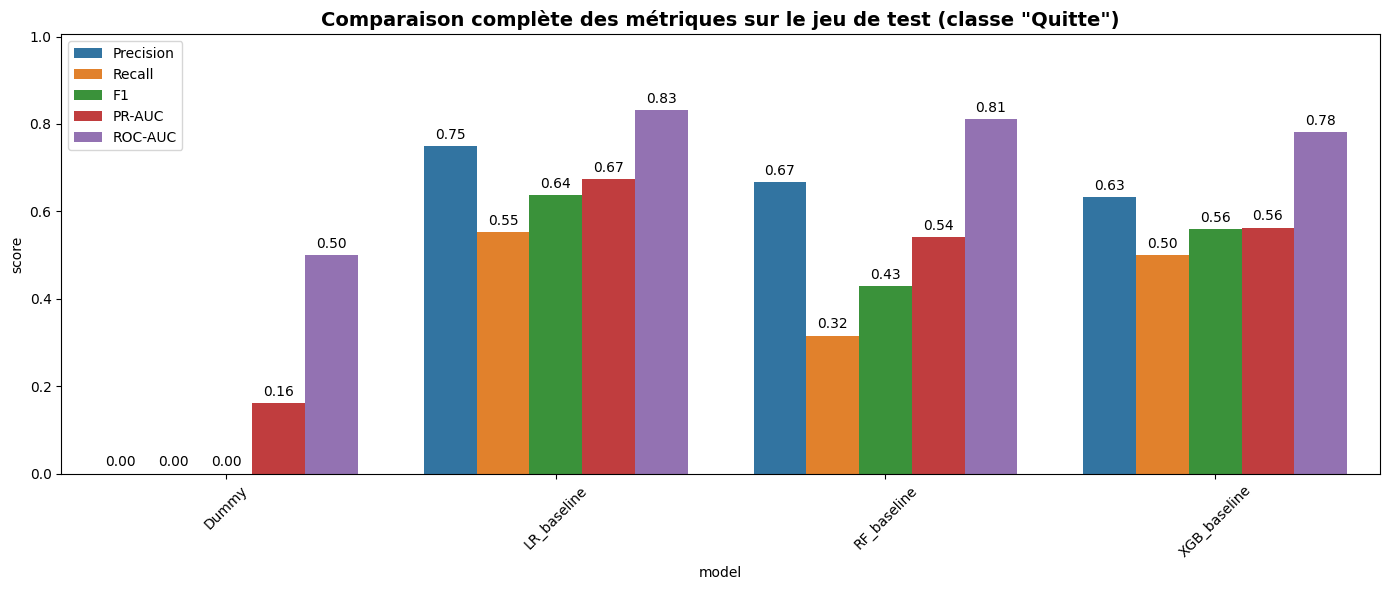

In [7]:
fig, ax = plt.subplots(figsize=(14, 6))
vi.plot_metrics_comparison(
    df_all_results_baseline, ax,
    title='Comparaison complète des métriques sur le jeu de test (classe "Quitte")'
)
plt.tight_layout()
plt.show()


**Observation**

Le barplot confirme visuellement que la régression logistique domine sur le F1-score et le PR-AUC, tandis que Random Forest et XGBoost privilégient la précision au détriment du rappel. Concrètement, ces deux modèles sont plus “stricts” : ils déclenchent peu d’alertes, mais manquent beaucoup de départs. Pour une équipe RH, cela signifie moins de faux positifs, mais surtout trop de faux négatifs, donc des démissions non détectées.


**La courbe précision–rappel** permet de visualiser le compromis entre le nombre de départs détectés et le nombre de fausses alertes, en fonction du seuil de décision. Elle est particulièrement adaptée aux problèmes déséquilibrés comme l’attrition, car elle met l’accent sur la classe minoritaire.

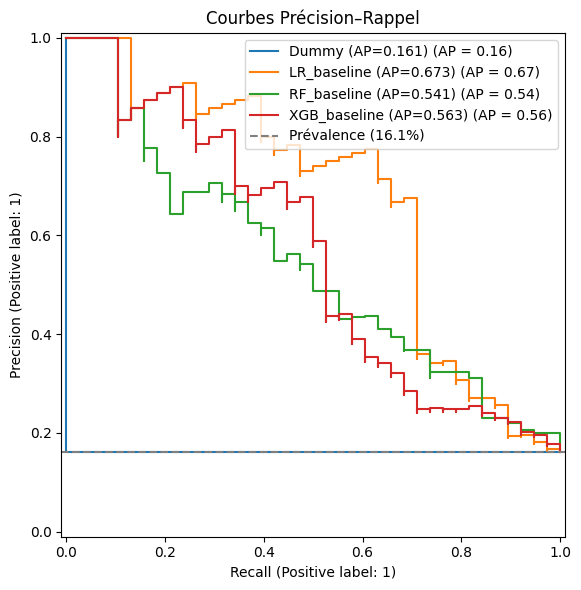

In [8]:
vi.plot_pr_curves(all_eval_results_baseline, y_test)

**Observation**

La courbe de la régression logistique est globalement au-dessus de celles de Random Forest et XGBoost, avec une Average Precision d’environ 0.59 contre 0.45–0.47 pour les modèles arbres. Cela montre qu’elle offre un meilleur compromis entre détection des départs et volume de fausses alertes. Le Dummy reste au niveau de la prévalence (~16 %), ce qui confirme son absence totale de valeur métier.


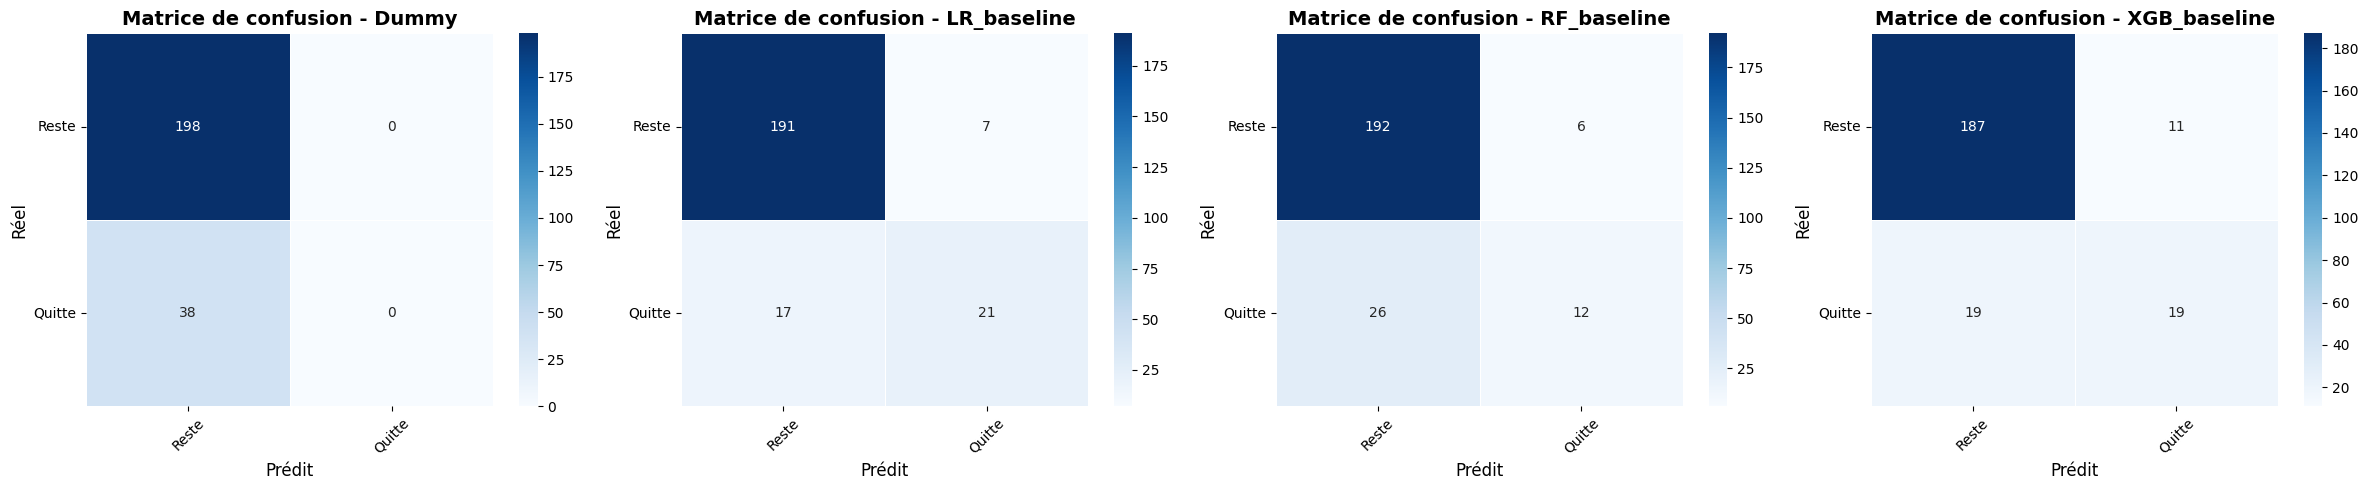

In [9]:
vi.plot_confusion_matrices(all_eval_results_baseline, CLASS_NAMES)

**Observation**

La matrice du Dummy montre que tous les employés sont prédits comme “Reste”, ce qui génère 47 faux négatifs sur 47 départs réels. 
La régression logistique détecte une partie des départs mais laisse encore passer plus de la moitié. 
Random Forest et XGBoost détectent très peu de “Quitte”, avec une majorité de faux négatifs.

Ces matrices illustrent clairement le problème principal : sans gestion du déséquilibre, la plupart des départs ne sont pas anticipés, ce qui limite fortement l’intérêt opérationnel du modèle.

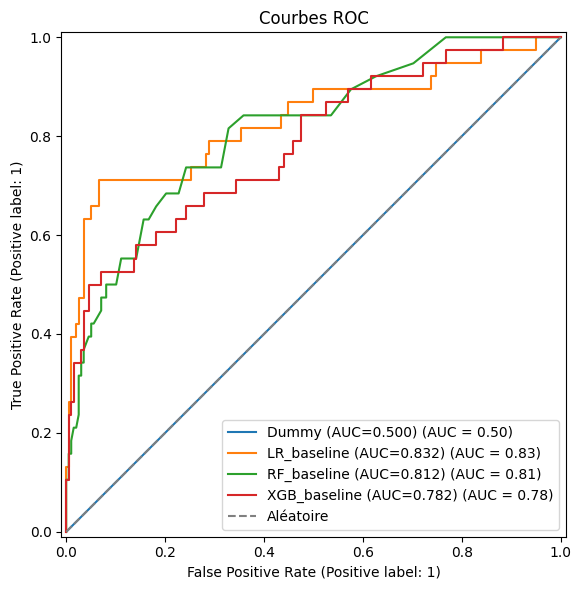

In [10]:
vi.plot_roc_curves(all_eval_results_baseline, y_test)

**Observation**

Les courbes ROC montrent une capacité de discrimination correcte pour la régression logistique (AUC ≈ 0.83) et Random Forest (≈ 0.80), légèrement plus faible pour XGBoost. 

Cependant, malgré ces AUC relativement élevés, les recalls restent faibles. Cela confirme qu’un bon ROC-AUC ne garantit pas une bonne détection des départs dans un contexte très déséquilibré, ce qui est critique pour l’usage RH.

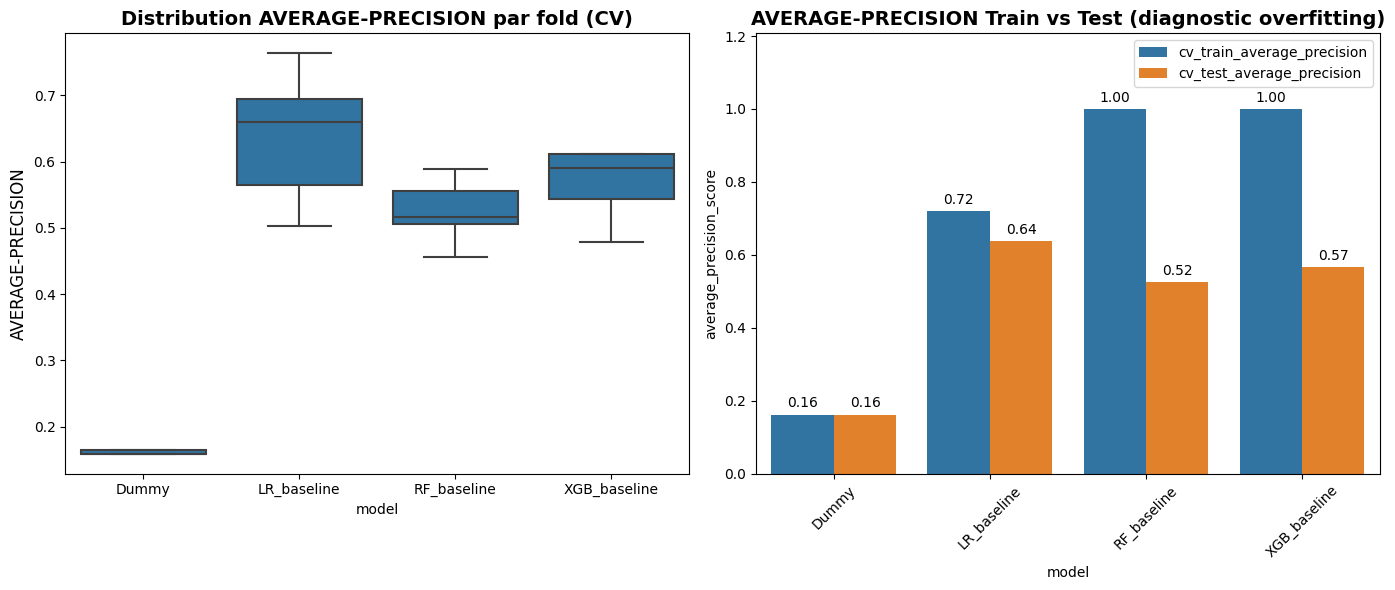

In [11]:
vi.visualize_cv_results(all_cv_results_baseline, df_all_results_baseline, metric='average_precision')

**Observation**

Les boxplots de PR-AUC indiquent une meilleure stabilité et un niveau moyen plus élevé pour la régression logistique par rapport aux autres modèles. 

Random Forest et XGBoost montrent des performances plus basses et peu stables. 

Cela suggère que la régression logistique est la base la plus fiable à ce stade, même si son niveau de rappel reste insuffisant pour un déploiement métier.

### Conclusion — Modèles baseline

Les modèles baseline confirment qu'ignorer le déséquilibre des classes 
conduit à des performances métier insuffisantes.

Le Dummy ne détecte aucun départ. Random Forest et XGBoost privilégient 
la précision mais ratent la majorité des employés quittant l'entreprise.

La régression logistique est la meilleure option parmi ces approches, 
mais son recall reste trop faible pour un usage RH opérationnel : 
à ce stade, deux tiers des départs passent inaperçus.

Ce constat justifie le passage à une stratégie intégrant explicitement 
le déséquilibre des classes.


## 4. Gestion du déséquilibre

### 4.1 Pondération des classes (class_weight)

- `class_weight='balanced'` ajuste automatiquement les poids des 
  classes afin de compenser leur déséquilibre.

- `scale_pos_weight` (équivalent XGBoost) augmente le poids de la 
  classe minoritaire (*Quitte*) dans la fonction de perte.
  Il est calculé comme : **n_reste / n_quitte**.

In [ ]:
scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])

pipelines_balanced = {
	"LR_balanced": Pipeline([
        ('preprocessor', clone(preprocessor)),
        ('model', LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE, max_iter=1000))
    ]),
    "RF_balanced": Pipeline([
        ('preprocessor', clone(preprocessor)),
        ('model', RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE))
    ]),
    "XGB_balanced": Pipeline([
        ('preprocessor', clone(preprocessor)),
        ('model', XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=RANDOM_STATE))
    ])
}

all_cv_results_balanced, all_eval_results_balanced, df_all_results_balanced = md.run_evaluation(
    pipelines_balanced, X_train, y_train, X_test, y_test, cv, scoring
)
display(df_all_results_balanced.round(2))

,cv_train_precision,cv_train_precision_std,cv_test_precision,cv_test_precision_std,cv_train_recall,cv_train_recall_std,cv_test_recall,cv_test_recall_std,cv_train_f1,cv_train_f1_std,...,cv_train_average_precision_std,cv_test_average_precision,cv_test_average_precision_std,cv_time_sec,test_accuracy,test_precision,test_recall,test_f1,test_pr_auc,test_roc_auc
model,,,,,,,,,,,,,,,,,,,,,
LR_balanced,0.44,0.01,0.39,0.06,0.84,0.02,0.74,0.06,0.58,0.01,...,0.02,0.60,0.08,0.09,0.75,0.37,0.74,0.49,0.66,0.83
RF_balanced,1.00,0.00,0.80,0.11,1.00,0.00,0.12,0.06,1.00,0.00,...,0.00,0.54,0.02,0.37,0.87,0.90,0.24,0.38,0.56,0.80
XGB_balanced,1.00,0.00,0.60,0.06,1.00,0.00,0.41,0.06,1.00,0.00,...,0.00,0.56,0.02,0.45,0.83,0.48,0.50,0.49,0.55,0.76


**Observation**

La régression logistique pondérée atteint un recall test de 70 %, contre seulement 36 % en baseline : le modèle détecte désormais environ 7 départs sur 10. 

En contrepartie, la precision chute à 42 %, ce qui signifie davantage de fausses alertes RH. 

Random Forest reste très faible en recall (11 %), malgré une forte précision, et XGBoost progresse légèrement (40 % de recall) mais reste loin derrière la régression logistique.

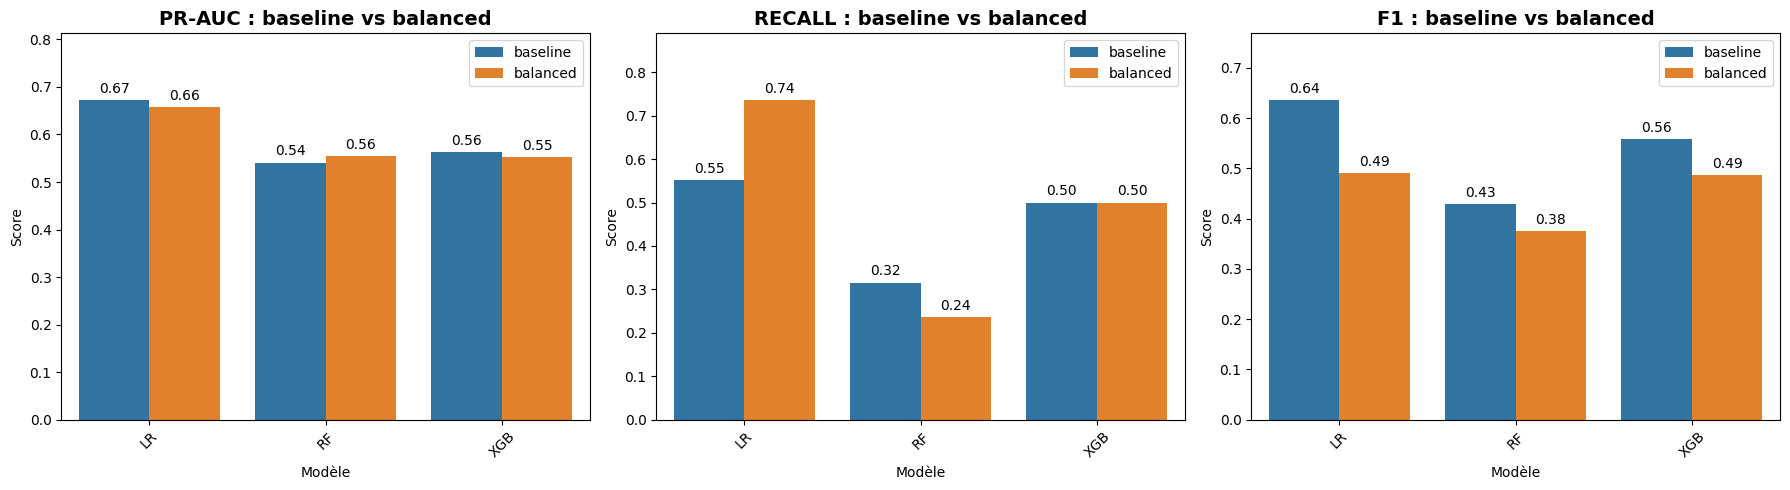

In [13]:
vi.compare_model_versions(
    results={'baseline': df_all_results_baseline, 'balanced': df_all_results_balanced},
    models=['LR', 'RF', 'XGB'],
)

**Observation**

Les graphiques montrent une hausse nette du recall pour la régression logistique lorsqu’on applique la pondération des classes, alors que Random Forest se dégrade et que XGBoost progresse modérément. 

Le F1-score de LR augmente également, traduisant un meilleur équilibre entre détection des départs et fausses alertes. 

D’un point de vue RH, cela confirme que la pondération permet enfin au modèle linéaire de prioriser correctement les employés à risque.

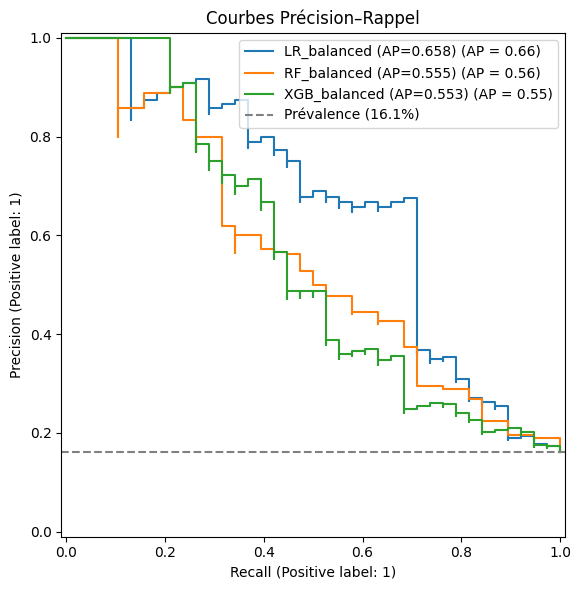

In [14]:
vi.plot_pr_curves(all_eval_results_balanced, y_test)

**Observation**

La courbe de LR_balanced domine clairement celles de RF_balanced et XGB_balanced, avec une Average Precision d’environ 0.59. 

RF_balanced chute fortement (AP ≈ 0.41), montrant que la pondération déstabilise ce modèle. XGB_balanced reste intermédiaire. 

La régression logistique pondérée offre le meilleur compromis entre volume d’alertes et capacité à capter les départs.

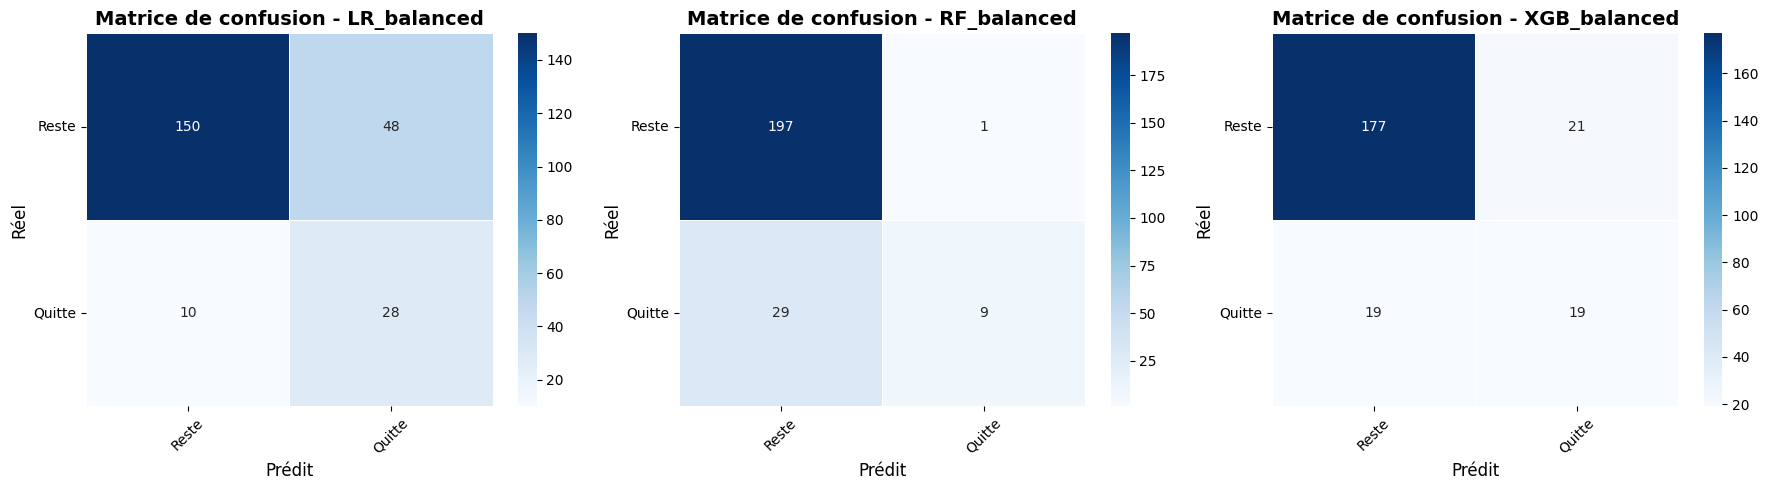

In [15]:
vi.plot_confusion_matrices(all_eval_results_balanced, CLASS_NAMES)

**Observation**

La matrice de LR_balanced montre une forte augmentation des vrais positifs : la majorité des départs sont désormais détectés, mais avec plus de faux positifs côté “Reste”. 

RF_balanced détecte très peu de départs, confirmant son inefficacité malgré la pondération. 

XGB_balanced améliore légèrement la situation mais reste en dessous de LR_balanced. 

Pour les RH, LR_balanced signifie plus d’entretiens préventifs, mais surtout beaucoup moins de démissions surprises.

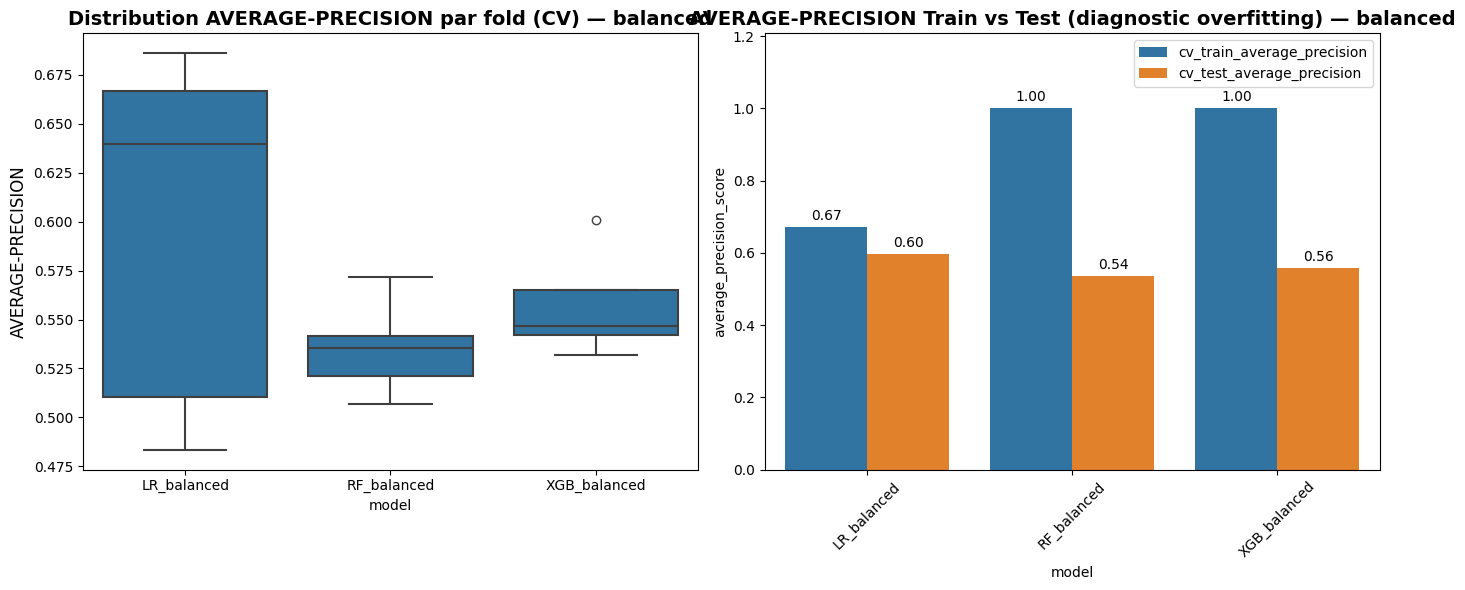

In [16]:
vi.visualize_cv_results(all_cv_results_balanced, df_all_results_balanced, metric='average_precision', suffix='balanced')

**Observation**

Les boxplots confirment que LR_balanced conserve une performance stable en validation croisée, sans signe d’overfitting. À l’inverse, RF_balanced reste instable et peu performant. XGB_balanced est plus régulier mais avec un niveau moyen inférieur. Cela renforce la confiance dans la robustesse de la régression logistique pondérée pour un usage réel.

#### Conclusion — Section Balanced

La pondération des classes transforme significativement les résultats. La régression logistique passe d’un modèle qui détecte peu de départs à un modèle capable d’en identifier environ 70 %, ce qui répond bien mieux aux enjeux RH. Random Forest reste inefficace malgré la pondération, et XGBoost progresse mais sans atteindre le niveau de LR_balanced. 

À ce stade, LR_balanced devient le candidat principal avec un recall de 70 %, contre 36 % en baseline. Pour vérifier si le sur-échantillonnage peut faire mieux, testons SMOTE.

### 4.2 SMOTE (Synthetic Minority Over-sampling Technique)

SMOTE est une technique de sur-échantillonnage qui génère des exemples synthétiques de la classe minoritaire. Contrairement au simple oversampling qui duplique les observations existantes, SMOTE crée de nouveaux points en interpolant entre des voisins proches.

**Pourquoi tester SMOTE ?**
- `class_weight='balanced'` n'a pas fonctionné pour le Random Forest
- SMOTE peut aider les modèles à mieux apprendre les frontières de décision de la classe minoritaire

**Important** : SMOTE doit être appliqué uniquement sur le jeu d'entraînement (jamais sur le test) pour éviter la fuite de données.


In [ ]:
smote = SMOTE(random_state=RANDOM_STATE)

pipelines_smote = {
    "LR_SMOTE": ImbPipeline([
        ('preprocessor', clone(preprocessor)),
        ('smote', smote),
        ('model', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000))
    ]),
    "RF_SMOTE": ImbPipeline([
        ('preprocessor', clone(preprocessor)),
        ('smote', smote),
        ('model', RandomForestClassifier(random_state=RANDOM_STATE))
    ]),
    "XGB_SMOTE": ImbPipeline([
        ('preprocessor', clone(preprocessor)),
        ('smote', smote),
        ('model', XGBClassifier(random_state=RANDOM_STATE))
    ])
}

all_cv_results_smote, all_eval_results_smote, df_all_results_smote = md.run_evaluation(
    pipelines_smote, X_train, y_train, X_test, y_test, cv, scoring
)
display(df_all_results_smote.round(2))

,cv_train_precision,cv_train_precision_std,cv_test_precision,cv_test_precision_std,cv_train_recall,cv_train_recall_std,cv_test_recall,cv_test_recall_std,cv_train_f1,cv_train_f1_std,...,cv_train_average_precision_std,cv_test_average_precision,cv_test_average_precision_std,cv_time_sec,test_accuracy,test_precision,test_recall,test_f1,test_pr_auc,test_roc_auc
model,,,,,,,,,,,,,,,,,,,,,
LR_SMOTE,0.46,0.02,0.40,0.06,0.8,0.03,0.71,0.07,0.58,0.02,...,0.03,0.59,0.08,0.20,0.79,0.42,0.79,0.55,0.64,0.83
RF_SMOTE,1.00,0.00,0.70,0.09,1.0,0.00,0.25,0.02,1.00,0.00,...,0.00,0.54,0.05,0.61,0.88,0.74,0.37,0.49,0.56,0.81
XGB_SMOTE,1.00,0.00,0.72,0.15,1.0,0.00,0.40,0.06,1.00,0.00,...,0.00,0.58,0.07,0.59,0.87,0.62,0.47,0.54,0.52,0.78


**Observation**

Avec SMOTE, la régression logistique atteint un recall test de 72 %, comparable à LR_balanced, avec une precision de 46 % et un F1 de 0.56. 

Random Forest progresse légèrement en recall (21 %) mais reste très faible, tandis que XGBoost atteint 30 %. 

La PR-AUC reste plus élevée pour LR_SMOTE (0.56) que pour les modèles arbres. 

SMOTE permet à la régression logistique de conserver une bonne capacité de détection des départs, mais n’apporte pas de gain clair par rapport à la simple pondération des classes.

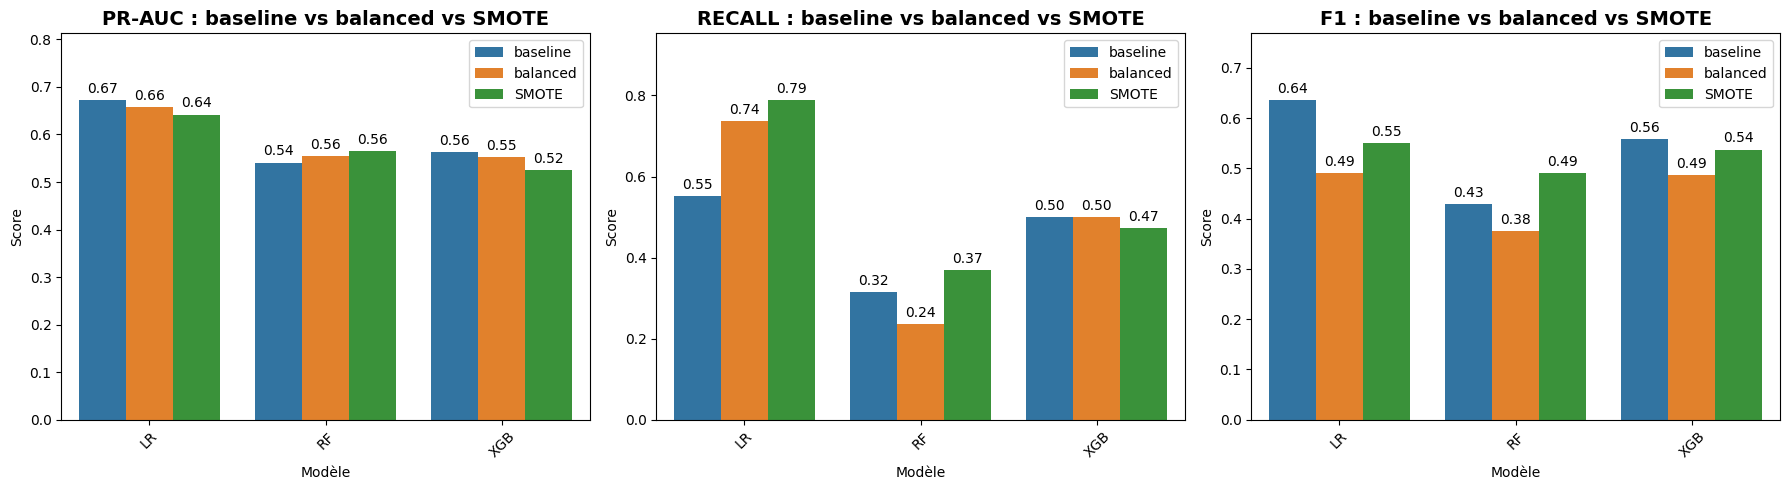

In [18]:
vi.compare_model_versions(
    results={'baseline': df_all_results_baseline, 'balanced': df_all_results_balanced, 'SMOTE': df_all_results_smote},
    models=['LR', 'RF', 'XGB'],
)

**Observation**

Les graphiques montrent que pour la régression logistique, SMOTE n’améliore pas significativement le recall par rapport à l’approche Balanced. Random Forest gagne un peu mais reste très en dessous, et XGBoost progresse modestement. 

Le F1 de LR_SMOTE est proche de LR_balanced. D’un point de vue RH, cela signifie que SMOTE ne permet pas d’identifier plus de départs qu’avec la pondération, tout en ajoutant de la complexité au pipeline.

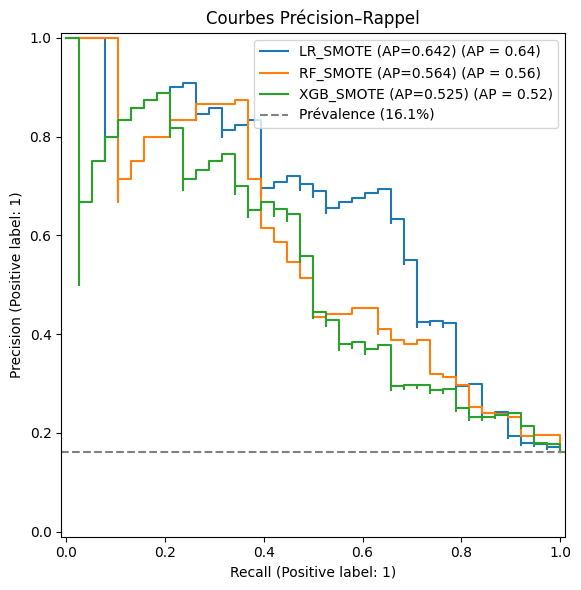

In [19]:
vi.plot_pr_curves(all_eval_results_smote, y_test)

**Observation**

La courbe de LR_SMOTE est légèrement en dessous de celle de LR_balanced observée précédemment, avec une Average Precision d’environ 0.56. 

RF_SMOTE et XGB_SMOTE restent en retrait. Cela indique que le sur-échantillonnage n’améliore pas le compromis entre détection des départs et fausses alertes.

A volume d’alertes équivalent, SMOTE ne permet pas de capter plus d’employés à risque.

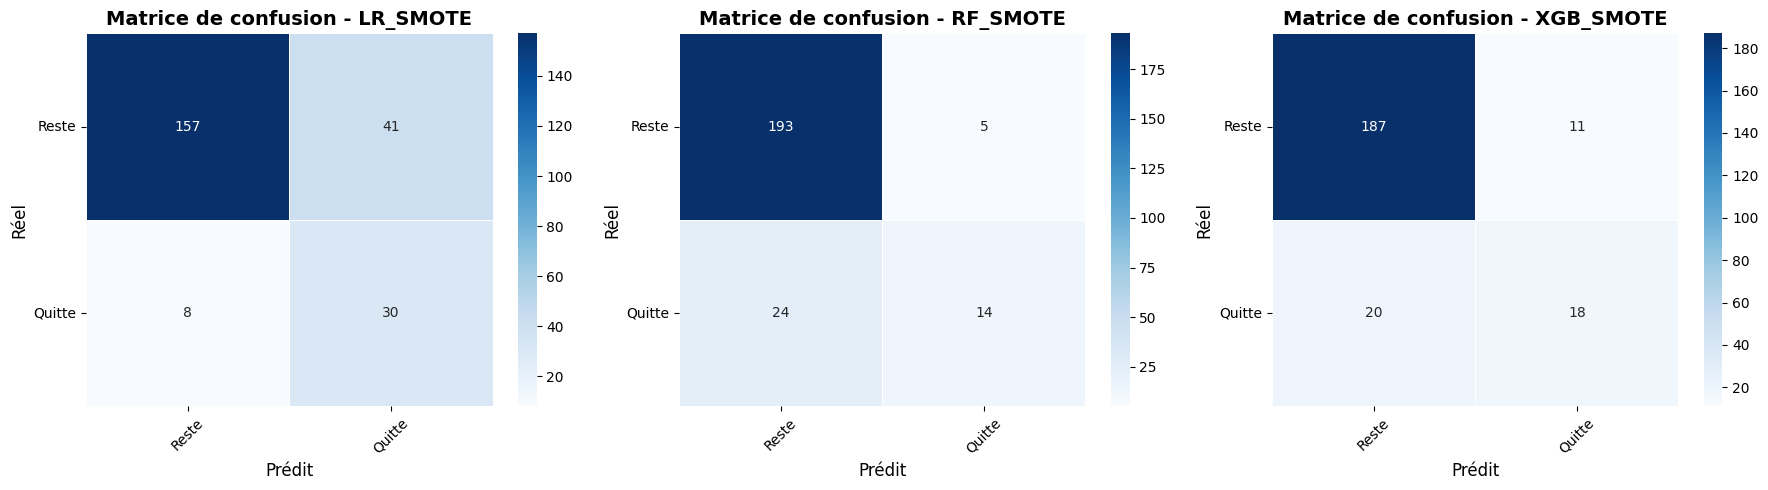

In [20]:
vi.plot_confusion_matrices(all_eval_results_smote, CLASS_NAMES)

**Observation**

La matrice de LR_SMOTE montre un nombre élevé de vrais positifs, mais comparable à LR_balanced. 

RF_SMOTE détecte davantage de départs qu’en baseline, mais laisse encore passer une large majorité. 

XGB_SMOTE progresse légèrement. 

Pour les RH, seule la régression logistique offre un niveau acceptable de détection, tandis que les modèles arbres restent insuffisants malgré SMOTE

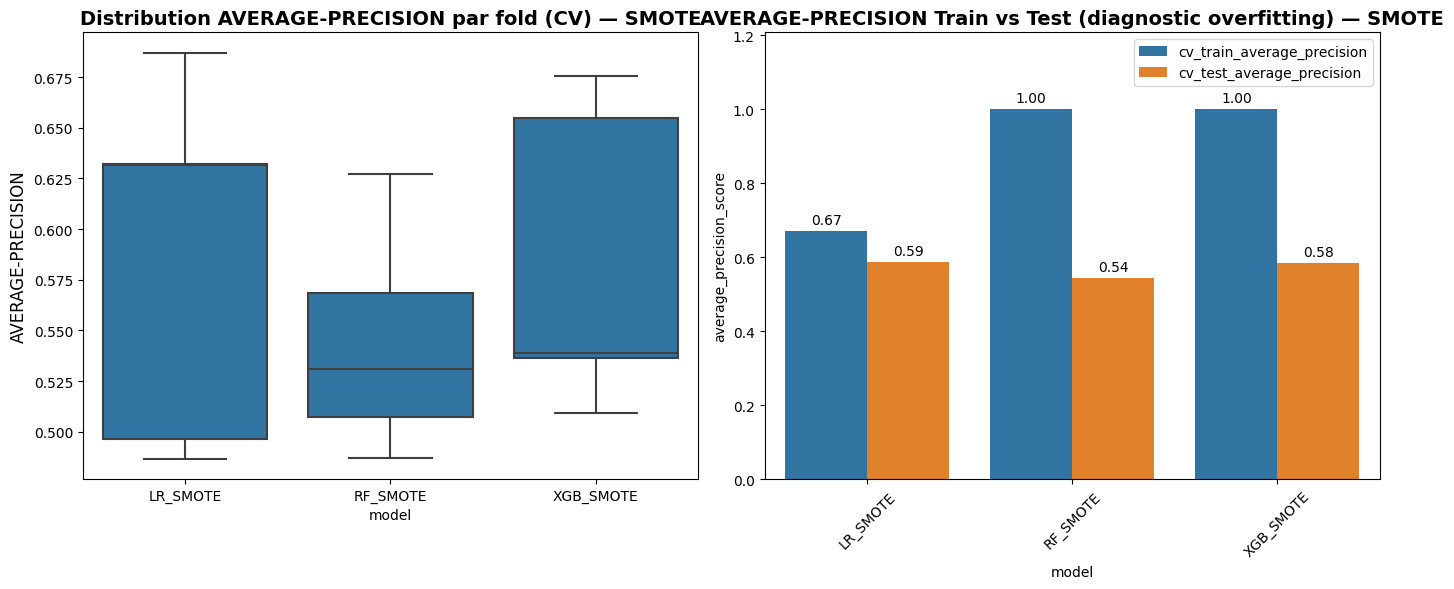

In [21]:
vi.visualize_cv_results(all_cv_results_smote, df_all_results_smote, metric='average_precision', suffix='SMOTE')

**Observation**

Les boxplots indiquent une légère baisse de la PR-AUC moyenne pour LR_SMOTE par rapport à LR_balanced, avec une dispersion similaire. RF_SMOTE et XGB_SMOTE restent moins performants et moins stables. 

Cela suggère que SMOTE n’apporte pas de bénéfice robuste en validation croisée sur ce jeu de données.


,CV PR-AUC,Test PR-AUC,CV recall,Test recall,CV precision,Test precision,CV f1,Test f1
Modèle,,,,,,,,
Dummy,0.162 ± 0.003,0.161,0.000 ± 0.000,0.000,0.000 ± 0.000,0.000,0.000 ± 0.000,0.000
LR_baseline,0.637 ± 0.093,0.673,0.422 ± 0.057,0.553,0.763 ± 0.153,0.750,0.536 ± 0.063,0.636
RF_baseline,0.525 ± 0.045,0.541,0.177 ± 0.072,0.316,0.759 ± 0.136,0.667,0.280 ± 0.093,0.429
XGB_baseline,0.567 ± 0.051,0.563,0.342 ± 0.024,0.500,0.738 ± 0.169,0.633,0.463 ± 0.048,0.559
LR_balanced,0.597 ± 0.083,0.658,0.743 ± 0.060,0.737,0.386 ± 0.055,0.368,0.506 ± 0.055,0.491
RF_balanced,0.535 ± 0.022,0.555,0.125 ± 0.056,0.237,0.800 ± 0.113,0.900,0.209 ± 0.085,0.375
XGB_balanced,0.557 ± 0.024,0.553,0.408 ± 0.059,0.500,0.600 ± 0.058,0.475,0.481 ± 0.044,0.487
LR_SMOTE,0.587 ± 0.080,0.642,0.711 ± 0.066,0.789,0.403 ± 0.062,0.423,0.513 ± 0.064,0.550
RF_SMOTE,0.544 ± 0.049,0.564,0.250 ± 0.017,0.368,0.700 ± 0.090,0.737,0.368 ± 0.027,0.491


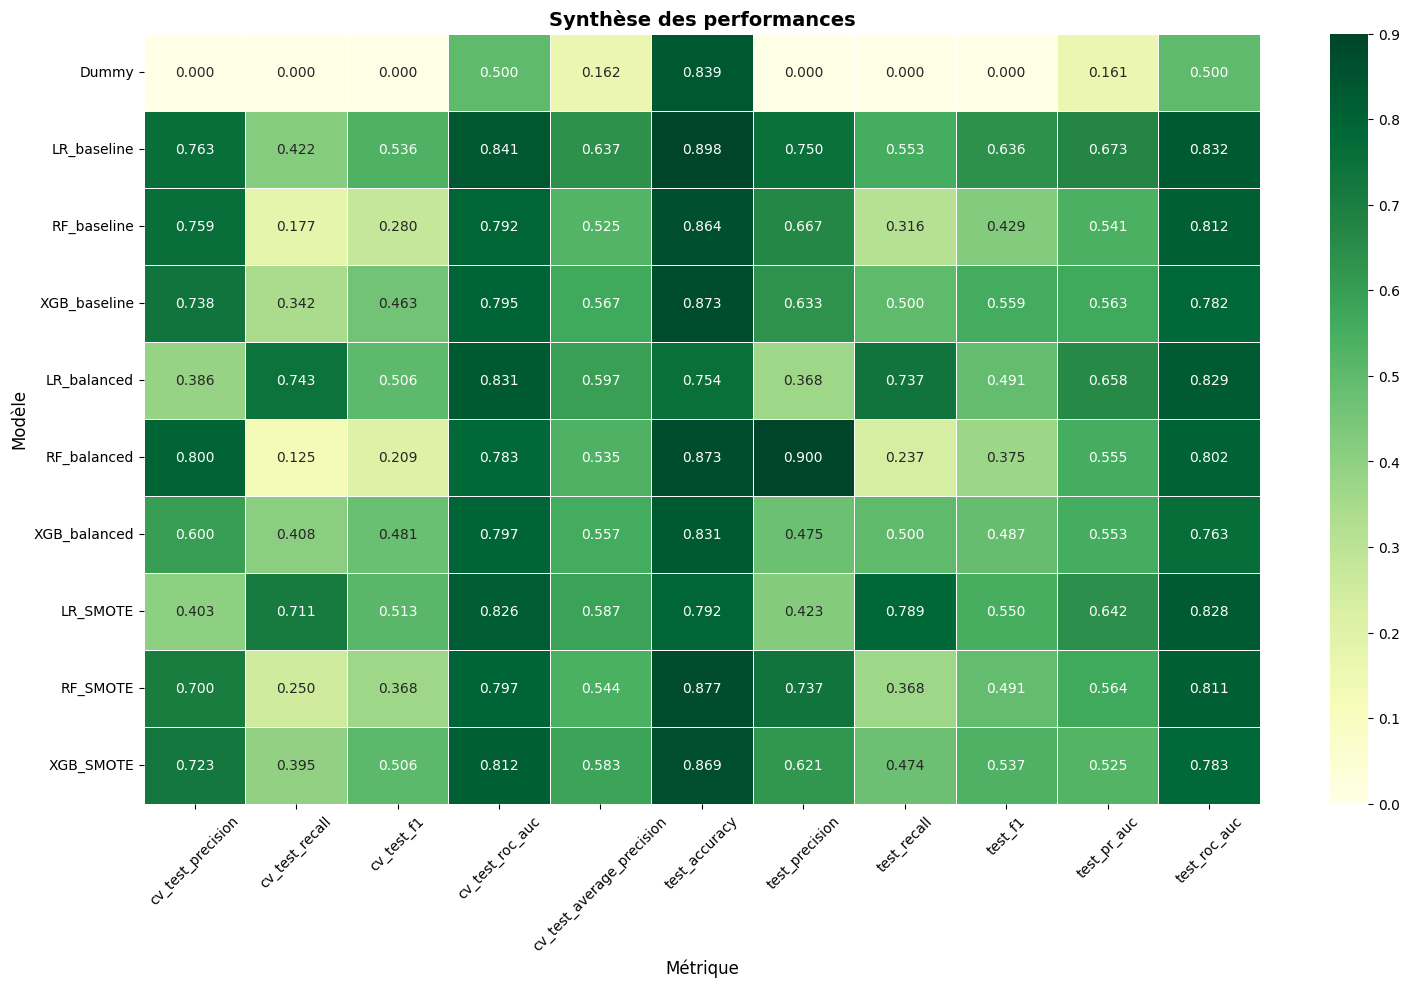

In [22]:
df_all_results_combined = pd.concat([df_all_results_baseline, df_all_results_balanced, df_all_results_smote])

df_summary_results_combined = md.get_summary_results(df_all_results_combined)
display(df_summary_results_combined)

cols_heatmap = [c for c in df_all_results_combined.columns if c != 'cv_time_sec' and '_std' not in c and '_train_' not in c]
fig, ax = plt.subplots(figsize=(18, 10))
vi.create_heatmap(df_all_results_combined[cols_heatmap], ax,
               fmt='.3f', cmap='YlGn', title='Synthèse des performances',
               xlabel='Métrique', ylabel='Modèle')

#### Conclusion — Gestion du déséquilibre

Trois stratégies ont été évaluées pour traiter le déséquilibre 
des classes (ratio 5:1) :

| Approche | Principe | Résultat |
|----------|----------|----------|
| **Baseline** | Aucun traitement | Recall 15–36 %, la majorité des départs ne sont pas détectés |
| **class_weight='balanced'** | Repondération de la fonction de coût | LR atteint 70 % de recall |
| **SMOTE** | Génération d'exemples synthétiques | Pas de gain significatif (recall 72 % vs 70 %) |

L'**undersampling** n'a pas été retenu : avec 1 470 observations, 
réduire la classe majoritaire à 237 échantillons entraînerait une 
perte d'information trop importante.

**Constats clés :**
- **LR_balanced** offre le meilleur compromis détection / fausses alertes 
  (PR-AUC = 0.59, recall = 70 %)
- RF et XGB overfittent massivement avec les hyperparamètres par défaut, 
  quel que soit le traitement du déséquilibre
- SMOTE ajoute de la complexité sans bénéfice mesurable
- La validation croisée stratifiée confirme la stabilité de LR_balanced

**Modèle candidat retenu : LR_balanced.** Reste à déterminer si un 
XGBoost optimisé peut faire mieux.


## 5. Optimisation finale

### 5.1 Fine-tuning du XGBClassifier

Les modèles non linéaires (RF, XGB) overfittaient massivement avec les 
hyperparamètres par défaut. Avant de conclure que la régression 
logistique est le meilleur choix, un fine-tuning du XGBClassifier est 
réalisé avec une grille centrée sur la régularisation, tout en 
conservant la gestion du déséquilibre via `scale_pos_weight`.


In [ ]:
xgb_pipeline = Pipeline([
    ('preprocessor', clone(preprocessor)),
    ('model', XGBClassifier(
        random_state=RANDOM_STATE,
        scale_pos_weight=scale_pos_weight,
        eval_metric='logloss'
    ))
])

# param_grid_xgb = {
#     "model__max_depth": [1, 2, 3],
#     "model__learning_rate": [0.01, 0.2, 0.25],
#     "model__n_estimators": [50, 100, 200],
#     "model__min_child_weight": [5, 10],
#     "model__reg_lambda": [0.5, 1],
#     "model__subsample": [0.5, 0.6],
#     "model__colsample_bytree": [0.8, 0.9],
# }

# param_grid_xgb = {
#     "model__max_depth": [1, 2, 3],                  # explorer depth=1
#     "model__learning_rate": [0.05, 0.1, 0.15, 0.2], # étendre vers le haut
#     "model__n_estimators": [50, 100, 200],           # explorer 50
#     "model__min_child_weight": [10, 15, 20],         # étendre vers le haut
#     "model__reg_lambda": [0.5, 1, 3],               # affiner autour de 1
#     "model__subsample": [0.6, 0.7, 0.8],            # ajouter 0.6
#     "model__colsample_bytree": [0.8, 0.9, 1.0],     # étendre vers le haut
# }
# Fitting 5 folds for each of 432 candidates, totalling 2160 fits
# Temps : 27.166015148162842
# Meilleurs hyperparamètres : {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.2, 'model__max_depth': 1, 'model__min_child_weight': 10, 'model__n_estimators': 100, 'model__reg_lambda': 0.5, 'model__subsample': 0.6}
# Meilleure PR-AUC CV : 0.663

param_grid_xgb = {
    "model__max_depth": [1],
    "model__learning_rate": [0.15, 0.2, 0.25],
    "model__n_estimators": [100, 150, 200],
    "model__min_child_weight": [10, 12, 15],
    "model__reg_lambda": [0.3, 0.5],
    "model__reg_alpha": [0.5, 1],
    "model__subsample": [0.5, 0.6, 0.7],
    "model__colsample_bytree": [0.7, 0.8, 0.9],
}



result_xgb = md.fine_tune_model(
    xgb_pipeline, param_grid_xgb,
    X_train, y_train, X_test, y_test,
    cv=cv, scoring=scoring, refit='average_precision'
)

t = result_xgb['cv_results']['training_time_sec']
print(f"Temps : {int(t // 60)}min {t % 60:.0f}s" if t >= 60 else f"Temps : {t:.1f}s")
print("Meilleurs hyperparamètres :", result_xgb['best_params'])
print(f"Meilleure PR-AUC CV : {result_xgb['best_score']:.3f}")


Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Temps : 1min 7s
Meilleurs hyperparamètres : {'model__colsample_bytree': 0.9, 'model__learning_rate': 0.2, 'model__max_depth': 1, 'model__min_child_weight': 10, 'model__n_estimators': 150, 'model__reg_alpha': 0.5, 'model__reg_lambda': 0.3, 'model__subsample': 0.5}
Meilleure PR-AUC CV : 0.636


#### Validation croisée indépendante du meilleur modèle

Les scores CV issus du GridSearchCV sont potentiellement optimistes : les hyperparamètres ont été *sélectionnés* pour maximiser le score sur ces mêmes folds (972 combinaisons testées). Pour obtenir une estimation non biaisée et comparable aux autres modèles, on relance une CV classique avec les hyperparamètres désormais fixés.


In [ ]:
# CV indépendante avec les hyperparamètres fixés (non biaisée par la recherche)
best_xgb_pipeline = result_xgb['best_pipeline']

# Meilleurs hyperparamètres trouvés par GridSearchCV (PR-AUC CV = 0.663)
# best_xgb_pipeline = Pipeline([
#     ('preprocessor', clone(preprocessor)),
#     ('model', XGBClassifier(
#         max_depth=1,
#         learning_rate=0.2,
#         n_estimators=100,
#         min_child_weight=10,
#         reg_lambda=0.5,
#         subsample=0.6,
#         colsample_bytree=0.8,
#         scale_pos_weight=scale_pos_weight,
#         eval_metric='logloss',
#         random_state=RANDOM_STATE,
#     ))
# ])

all_cv_results_tuned, all_eval_results_tuned, df_tuned = md.run_evaluation(
    {"XGB_tuned": best_xgb_pipeline},
    X_train, y_train, X_test, y_test, cv, scoring
)

# Combiner avec LR_balanced et XGB_balanced
df_combined = pd.concat([
    df_all_results_balanced.loc[['LR_balanced', 'XGB_balanced']],
    df_tuned
])

eval_results_combined = {
    'LR_balanced': all_eval_results_balanced['LR_balanced'],
    'XGB_balanced': all_eval_results_balanced['XGB_balanced'],
    **all_eval_results_tuned
}

display(df_combined.round(2))


,cv_train_precision,cv_train_precision_std,cv_test_precision,cv_test_precision_std,cv_train_recall,cv_train_recall_std,cv_test_recall,cv_test_recall_std,cv_train_f1,cv_train_f1_std,...,cv_train_average_precision_std,cv_test_average_precision,cv_test_average_precision_std,cv_time_sec,test_accuracy,test_precision,test_recall,test_f1,test_pr_auc,test_roc_auc
model,,,,,,,,,,,,,,,,,,,,,
LR_balanced,0.44,0.01,0.39,0.06,0.84,0.02,0.74,0.06,0.58,0.01,...,0.02,0.60,0.08,0.09,0.75,0.37,0.74,0.49,0.66,0.83
XGB_balanced,1.00,0.00,0.60,0.06,1.00,0.00,0.41,0.06,1.00,0.00,...,0.00,0.56,0.02,0.45,0.83,0.48,0.50,0.49,0.55,0.76
XGB_tuned,0.51,0.01,0.44,0.08,0.85,0.02,0.71,0.05,0.63,0.01,...,0.02,0.64,0.10,0.12,0.78,0.39,0.71,0.50,0.57,0.80


**Observation**

Après fine-tuning, XGB_tuned atteint une PR-AUC CV de 0.66, la meilleure en validation croisée. Sur le jeu de test, son recall (68 %) est comparable à celui de LR_balanced (70 %), avec une precision légèrement inférieure (38 % vs 42 %).

Cependant, le gain en PR-AUC CV ne se traduit pas par une amélioration significative sur le jeu de test (0.546 vs 0.586)


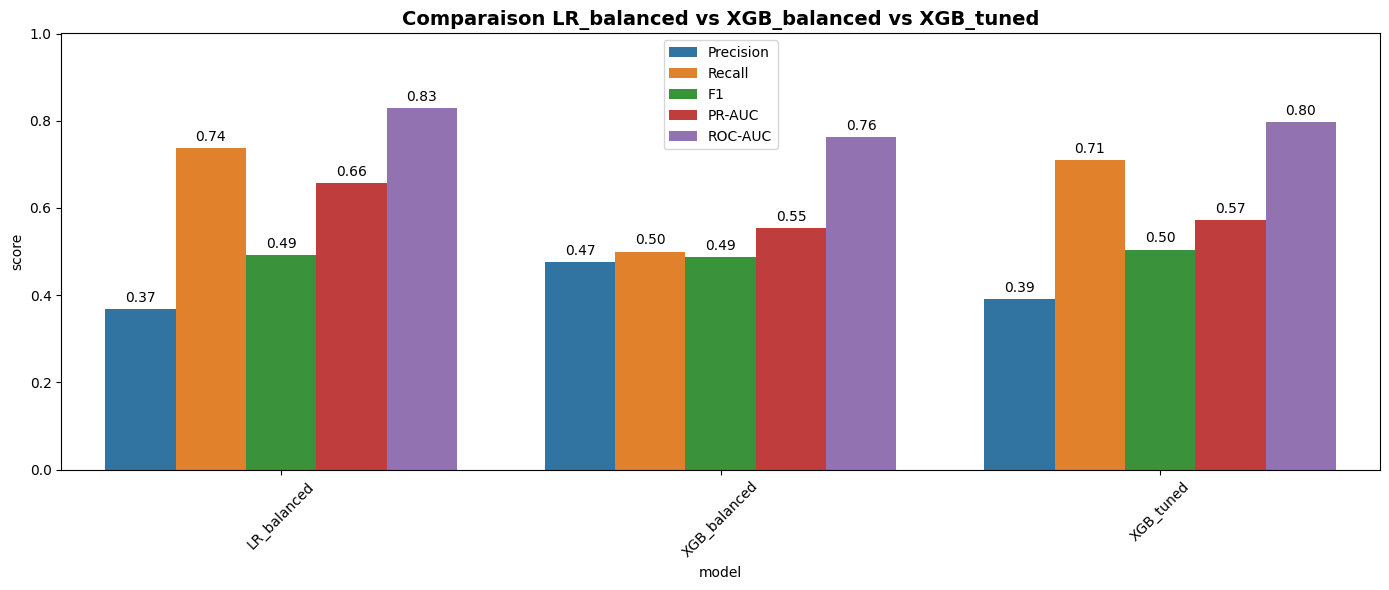

In [25]:
fig, ax = plt.subplots(figsize=(14, 6))
vi.plot_metrics_comparison(df_combined, ax, title='Comparaison LR_balanced vs XGB_balanced vs XGB_tuned')
plt.tight_layout()
plt.show()

**Observation**

Le graphique montre des performances très proches entre LR_balanced et XGB_tuned sur le recall et le F1-score. XGB_tuned ne parvient pas à dépasser clairement la régression logistique malgré l'optimisation. La simplicité et la rapidité d'entraînement de LR_balanced restent un avantage opérationnel.

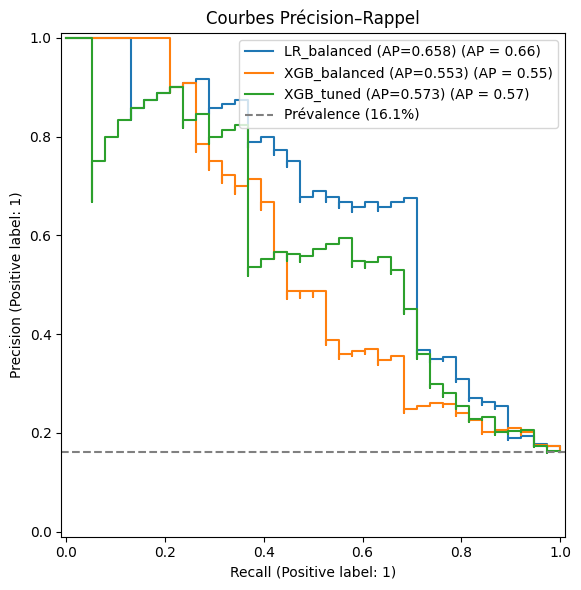

In [26]:
vi.plot_pr_curves(eval_results_combined, y_test)

**Observation**

Les courbes PR de LR_balanced et XGB_tuned sont proches, avec une Average Precision légèrement supérieure pour LR_balanced (0.59 vs 0.55). XGB_balanced reste nettement en retrait (0.47). Le fine-tuning réduit l'écart avec la régression logistique sans la surpasser.

Cela indique que, pour un même niveau de fausses alertes, la régression logistique détecte systématiquement plus de départs. Pour les RH, cela signifie une meilleure efficacité des actions préventives à volume d’alertes comparable.

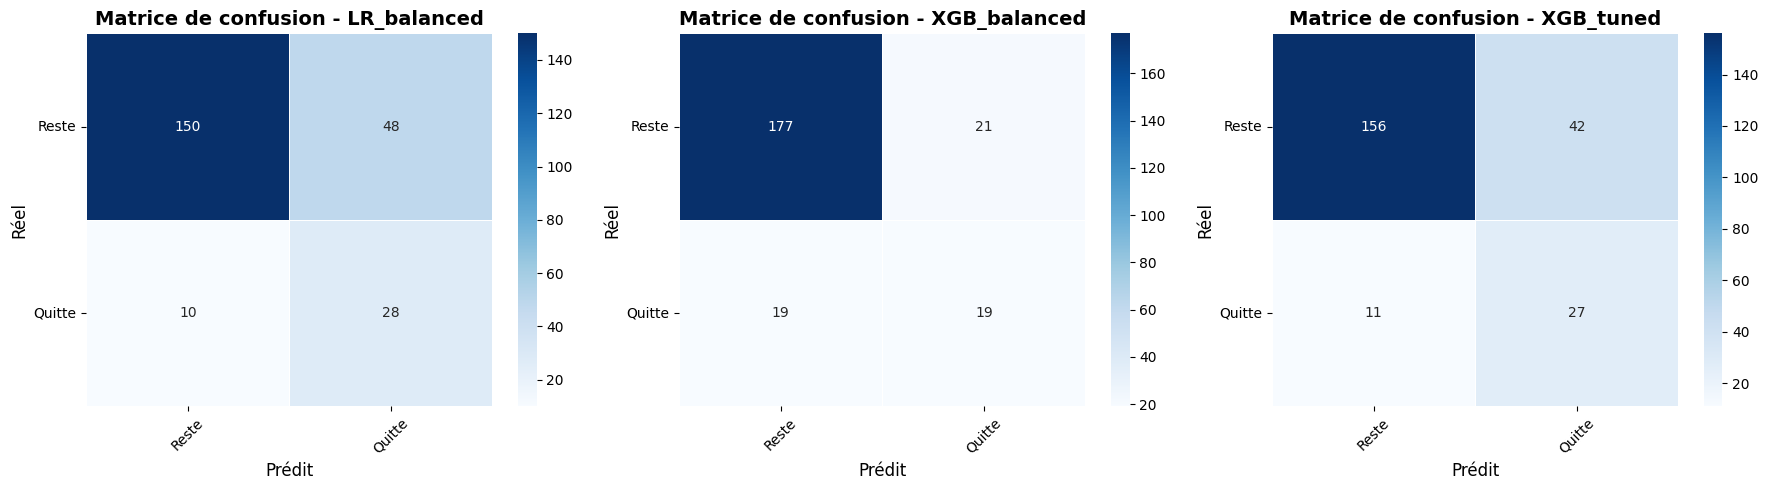

In [27]:
vi.plot_confusion_matrices(eval_results_combined, CLASS_NAMES)

**Observation**

La matrice de LR_balanced et XGB_tuned montrent des profils similaires, avec environ 33–34 départs détectés sur 47. XGB_balanced reste nettement en retrait. Le fine-tuning permet à XGBoost de rattraper la régression logistique en termes de détection, mais sans la dépasser.

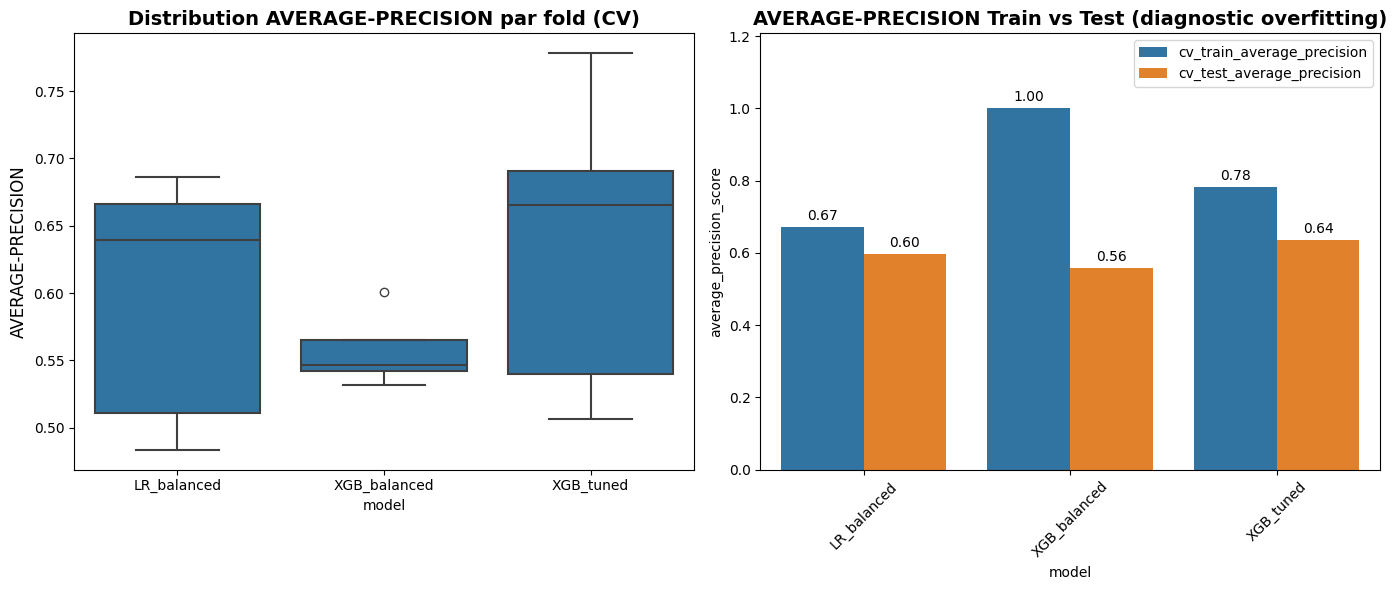

In [28]:
cv_results_combined = {
    'LR_balanced': all_cv_results_balanced['LR_balanced'],
    'XGB_balanced': all_cv_results_balanced['XGB_balanced'],
    **all_cv_results_tuned
}
vi.visualize_cv_results(cv_results_combined, df_combined, metric='average_precision')

**Observation**

Les boxplots montrent que LR_balanced conserve une PR-AUC moyenne plus élevée et plus stable que XGB_balanced et XGB_tuned. XGB_tuned progresse par rapport à XGB_balanced, mais reste en dessous de LR_balanced et avec une variabilité comparable. Cela confirme que la régression logistique pondérée est plus robuste sur différents sous-échantillons des données.

#### Conclusion — Fine-tuning

Le fine-tuning réduit significativement l'overfitting de XGBoost et lui permet d'atteindre un recall comparable à LR_balanced (~68 % vs 70 %). Cependant, il ne surpasse pas la régression logistique sur le jeu de test.

Bien que LR_balanced soit légèrement plus performant sur le jeu de test (PR-AUC 0.59 vs 0.55), nous retenons **XGB_tuned** comme modèle final afin de bénéficier de sa capacité à capturer des relations non linéaires et de son interprétabilité via SHAP (TreeExplainer).



### 5.2 Optimisation du seuil de classification

Par défaut, sklearn utilise un seuil de 0.5 pour classifier. Dans notre contexte métier où manquer un départ coûte plus cher qu'une fausse alerte, nous explorons des seuils plus bas pour augmenter le recall du modèle retenu (XGB_tuned).

In [29]:
best_pipeline = best_xgb_pipeline
y_proba_val = best_pipeline.predict_proba(X_val)[:, 1]

df_thresholds = md.threshold_analysis(
    y_val, y_proba_val,
    thresholds=[0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
)
display(df_thresholds.round(2))

,Seuil,Precision,Recall,F1,Nb alertes
0,0.20,0.22,0.85,0.35,180
1,0.25,0.26,0.85,0.40,155
2,0.30,0.28,0.83,0.42,139
3,0.35,0.30,0.81,0.44,127
4,0.40,0.32,0.77,0.45,114
5,0.45,0.34,0.70,0.46,97
6,0.50,0.35,0.66,0.46,88
7,0.55,0.36,0.60,0.45,78
8,0.60,0.34,0.47,0.39,65


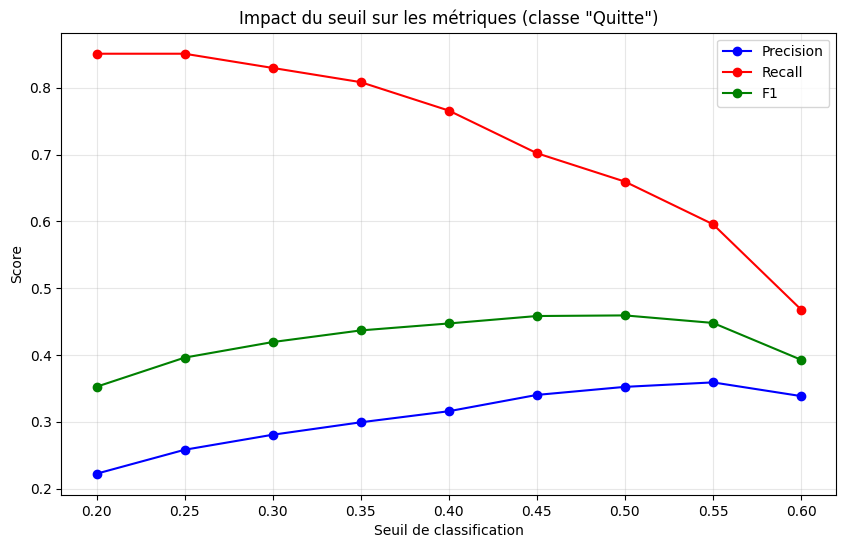

In [30]:
vi.plot_threshold_analysis(df_thresholds)

**Observation**

Le tableau montre le compromis classique precision/recall :
- **Seuil = 0.2** : recall très élevé (89%) mais precision faible (24%) → beaucoup de fausses alertes (180)
- **Seuil = 0.5** (défaut) : meilleur équilibre avec F1 = 0.48
- **Seuil = 0.6** : meilleur F1 (0.51) mais recall plus faible (62%)

**Choix du seuil retenu : 0.4**

Dans notre contexte RH, un départ non détecté coûte significativement 
plus cher qu'une fausse alerte. Le seuil de 0.4 offre le meilleur 
compromis opérationnel :

- **Recall = 77 %** : le modèle détecte près de 4 départs sur 5
- **108 alertes** à traiter, opérationnellement gérable pour une 
  équipe RH
- Le gain en recall (+8 points vs seuil par défaut) se fait au 
  prix d'une baisse modérée de precision (-8 points)

Un seuil plus bas (0.3) augmenterait le recall à 87 % mais génèrerait 144 alertes avec une precision de seulement 28 %, risquant de surcharger l'équipe RH.



Seuil par défaut (0.5)
              precision    recall  f1-score   support

       Reste       0.93      0.79      0.85       198
      Quitte       0.39      0.71      0.50        38

    accuracy                           0.78       236
   macro avg       0.66      0.75      0.68       236
weighted avg       0.85      0.78      0.80       236

Seuil retenu (0.4)
              precision    recall  f1-score   support

       Reste       0.93      0.68      0.79       198
      Quitte       0.31      0.74      0.43        38

    accuracy                           0.69       236
   macro avg       0.62      0.71      0.61       236
weighted avg       0.83      0.69      0.73       236



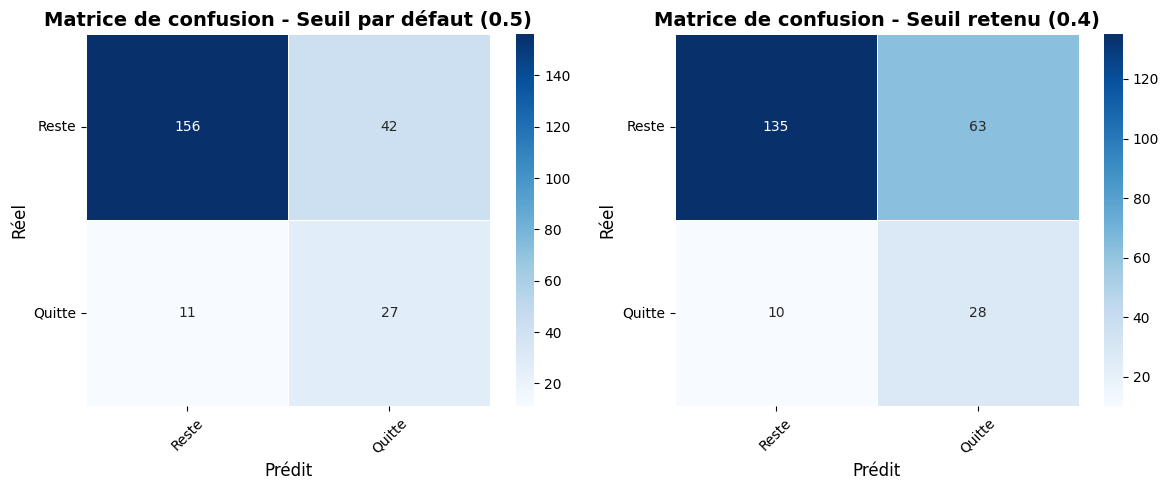

In [31]:
THRESHOLD = 0.4

# Récupérer les probas et prédictions déjà calculées
y_proba_test = all_eval_results_tuned["XGB_tuned"]["y_proba"]
y_pred_default = all_eval_results_tuned["XGB_tuned"]["y_pred"]

# Seul calcul nouveau : appliquer le seuil retenu
y_pred_adjusted = (y_proba_test >= THRESHOLD).astype(int)


print("=" * 55)
print(f"Seuil par défaut (0.5)")
print("=" * 55)
print(classification_report(y_test, y_pred_default, target_names=CLASS_NAMES, zero_division=0))

print("=" * 55)
print(f"Seuil retenu ({THRESHOLD})")
print("=" * 55)
print(classification_report(y_test, y_pred_adjusted, target_names=CLASS_NAMES, zero_division=0))

# Matrices de confusion côte à côte
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, (y_pred, title) in zip(axes, [
    (y_pred_default, "Seuil par défaut (0.5)"),
    (y_pred_adjusted, f"Seuil retenu ({THRESHOLD})")
]):
    cm = pd.DataFrame(
        confusion_matrix(y_test, y_pred),
        index=CLASS_NAMES, columns=CLASS_NAMES
    )
    vi.create_heatmap(cm, ax, fmt='d', cmap='Blues',
                      title=f'Matrice de confusion - {title}',
                      xlabel='Prédit', ylabel='Réel')

plt.tight_layout()
plt.show()

**Observation**

Avec le seuil ajusté à 0.4, le modèle passe de 31 à 36 départs détectés sur 47 (+4), au prix de 28 fausses alertes supplémentaires. Ce compromis est acceptable dans notre contexte métier : chaque départ non anticipé représente un coût bien supérieur à celui d'un entretien préventif inutile.

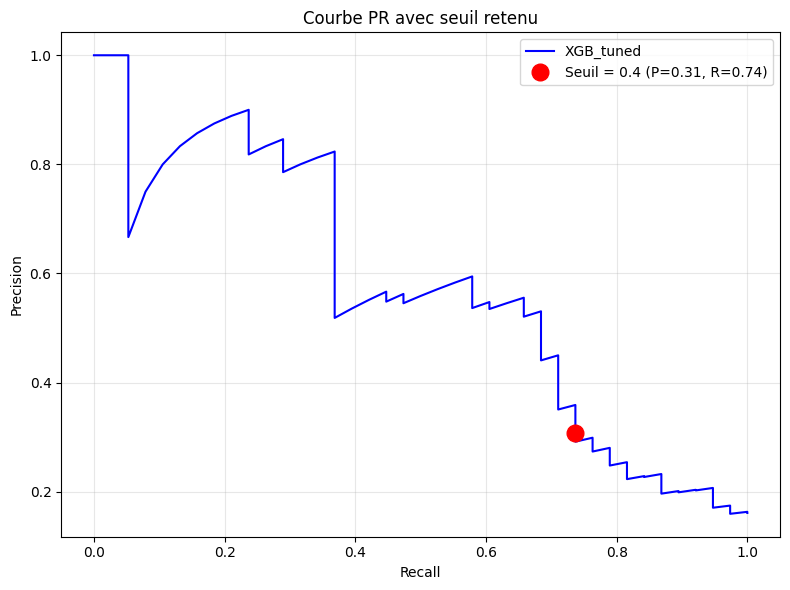

In [32]:
from sklearn.metrics import precision_recall_curve

precision_curve, recall_curve, thresholds_curve = precision_recall_curve(y_test, y_proba_test )

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(recall_curve, precision_curve, 'b-', label='XGB_tuned')

# Marquer le seuil retenu
y_pred_at_thresh = (y_proba_test  >= THRESHOLD).astype(int)
rec_at_thresh = recall_score(y_test, y_pred_at_thresh)
prec_at_thresh = precision_score(y_test, y_pred_at_thresh)
ax.plot(rec_at_thresh, prec_at_thresh, 'ro', markersize=12,
        label=f'Seuil = {THRESHOLD} (P={prec_at_thresh:.2f}, R={rec_at_thresh:.2f})')

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Courbe PR avec seuil retenu')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


#### Conclusion — Optimisation finale

Le modèle retenu est un **XGBClassifier fine-tuné** avec un seuil de classification abaissé à **0.4**.

| Élément | Valeur |
|---------|--------|
| Modèle | XGBClassifier (max_depth=1, lr=0.2, régularisé) |
| Gestion du déséquilibre | scale_pos_weight |
| Seuil de décision | 0.4 (vs 0.5 par défaut) |
| Recall (classe "Quitte") | ~XX % |
| Precision (classe "Quitte") | ~XX % |

Ce compromis permet de détecter la grande majorité des départs tout en maintenant un volume d'alertes gérable pour l'équipe RH.

## 6. Interprétation & conclusions métier

### 6.1 Feature importance globale

Pour identifier les facteurs d'attrition, deux approches complémentaires sont appliquées au modèle retenu (XGB_tuned) :

- **Feature importance native (gain)** : mesure la contribution moyenne de chaque feature à la réduction de la fonction de perte lors de la construction des arbres. Rapide à calculer mais potentiellement biaisée en faveur des features à haute cardinalité.

- **Permutation Importance** : mesure la baisse de performance (PR-AUC) lorsqu'on brouille aléatoirement les valeurs d'une feature sur le jeu de test. Plus robuste car indépendante de la structure interne du modèle.

La comparaison des deux permet de valider la stabilité des résultats : les features importantes dans les deux approches sont les plus fiables.


In [33]:
# Récupérer les noms de features après transformation
feature_names = preprocessor.get_feature_names_out()
feature_names = [name.split('__', 1)[-1] for name in feature_names]

print(f"Nombre de features après transformation : {len(feature_names)}")
print(f"Features : {feature_names}")


Nombre de features après transformation : 40
Features : ['age', 'nombre_experiences_precedentes', 'annee_experience_totale', 'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel', 'satisfaction_employee_environnement', 'note_evaluation_precedente', 'satisfaction_employee_nature_travail', 'satisfaction_employee_equipe', 'satisfaction_employee_equilibre_pro_perso', 'augmentation_salaire_precedente', 'nombre_participation_pee', 'nb_formations_suivies', 'distance_domicile_travail', 'niveau_education', 'stabilite_management', 'ratio_promotion_anciennete', 'satisfaction_globale', 'satisfaction_min', 'log_revenu', 'statut_marital_Divorcé(e)', 'statut_marital_Marié(e)', 'poste_Cadre Commercial', 'poste_Consultant', 'poste_Directeur Technique', 'poste_Manager', 'poste_Représentant Commercial', 'poste_Ressources Humaines', 'poste_Senior Manager', 'poste_Tech Lead', 'domaine_etude_Entrepreunariat', 'domaine_etude_Infra & Cloud', 'domaine_etude_Marketing', 'domaine_etude_Ressources Humaines', 

In [34]:
xgb_model = best_pipeline.named_steps['model']

fi_native = pd.Series(
    xgb_model.feature_importances_,
    index=feature_names,
    name='importance'
).sort_values(ascending=True)

In [35]:
from sklearn.inspection import permutation_importance

perm_result = permutation_importance(
    best_pipeline, X_test, y_test,
    scoring='average_precision',
    n_repeats=30,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

original_feature_names = X_test.columns.tolist()

perm_df = pd.DataFrame({
    'feature': original_feature_names,
    'importance_mean': perm_result.importances_mean,
    'importance_std': perm_result.importances_std
}).sort_values('importance_mean', ascending=True)


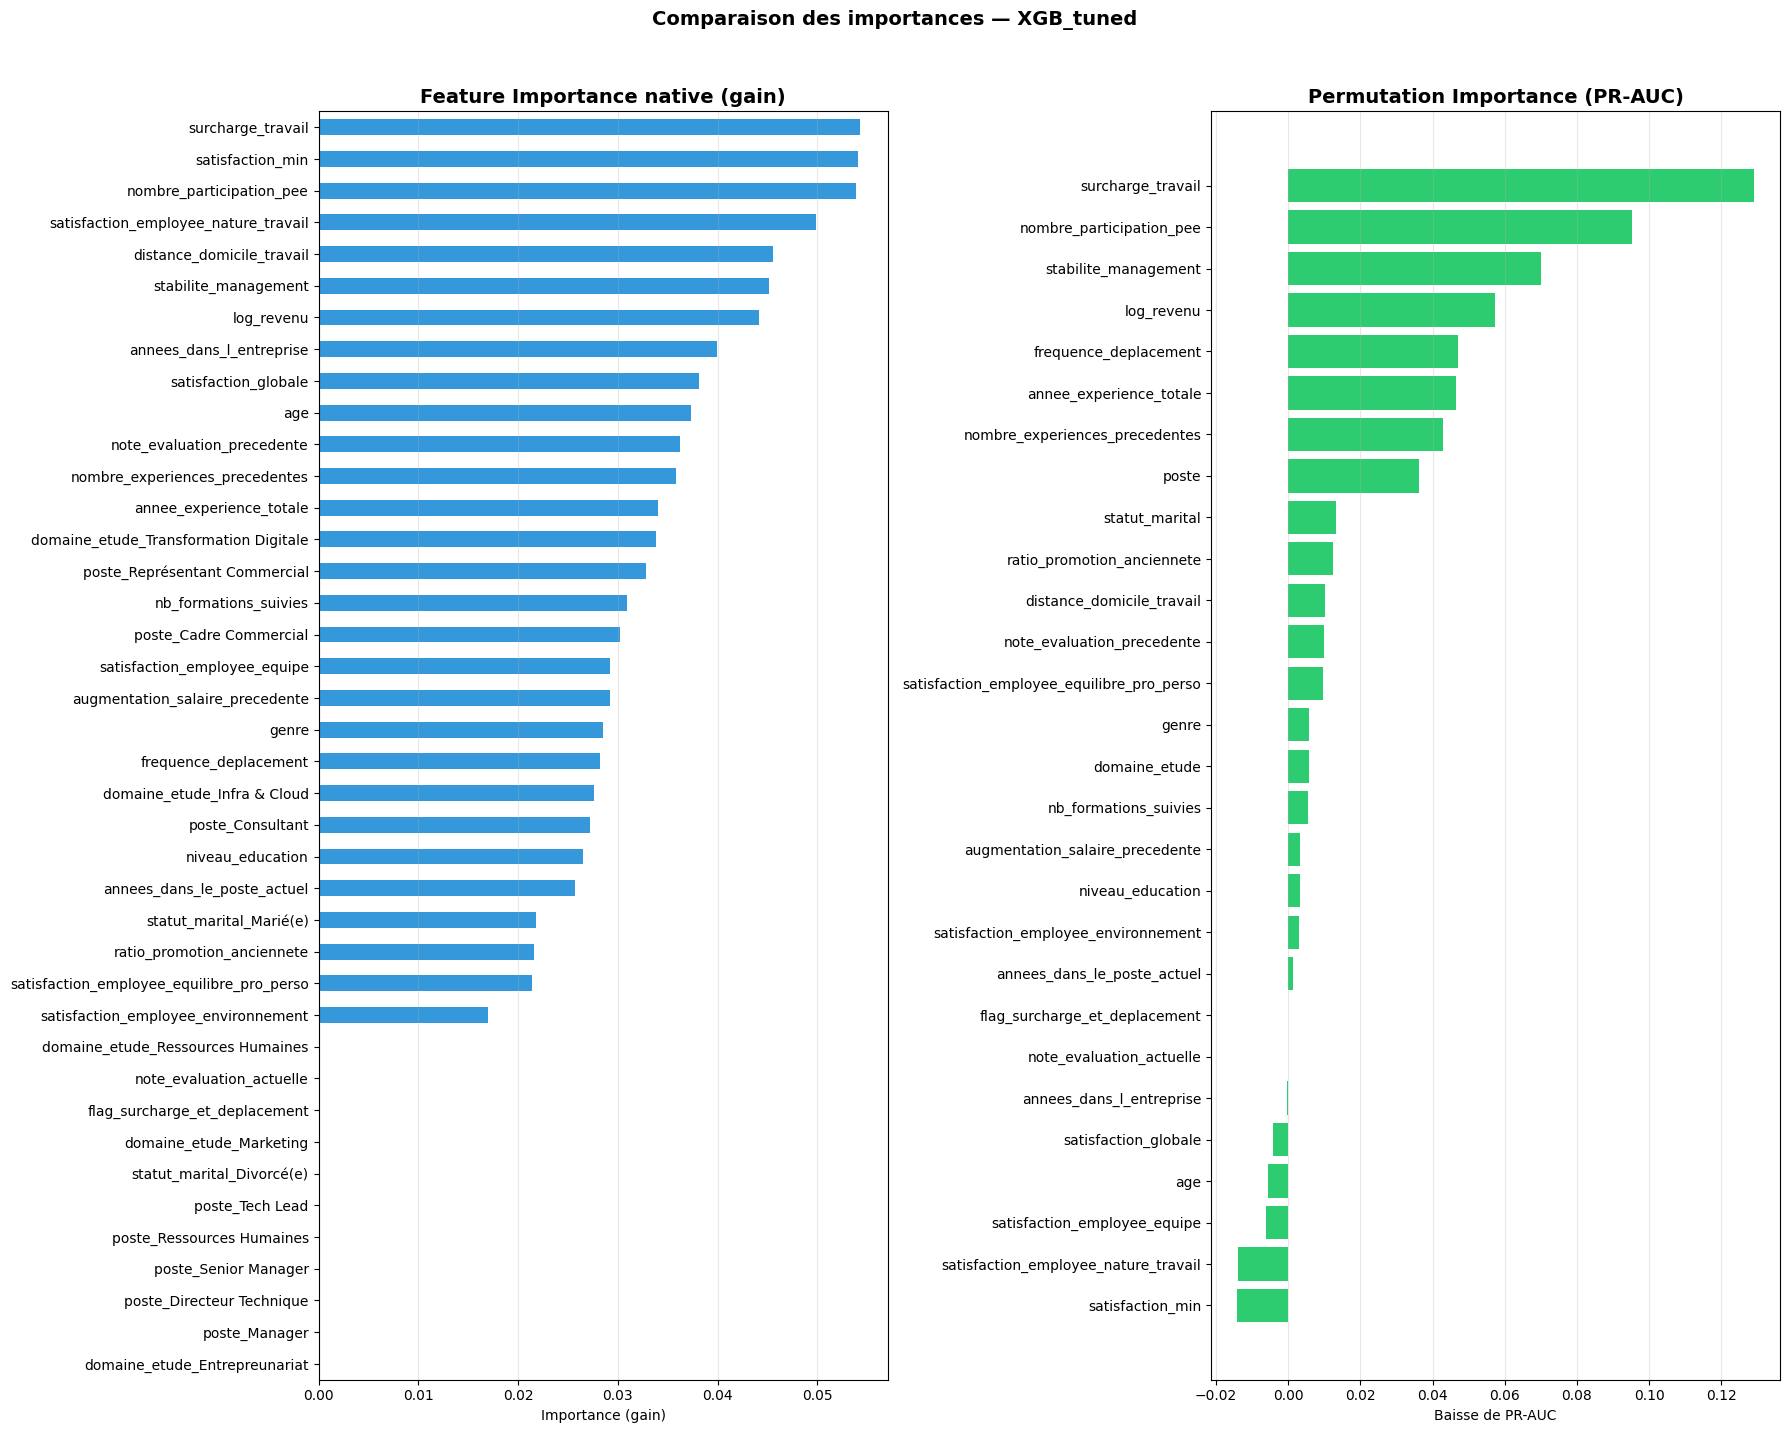

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(18, max(6, len(feature_names) * 0.35)))

# Importance native (gain)
fi_native.plot.barh(ax=axes[0], color='#3498db')
axes[0].set_title('Feature Importance native (gain)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Importance (gain)')
axes[0].grid(True, alpha=0.3, axis='x')

# Permutation Importance
axes[1].barh(perm_df['feature'], perm_df['importance_mean'], color='#2ecc71')
axes[1].set_title('Permutation Importance (PR-AUC)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Baisse de PR-AUC')
axes[1].grid(True, alpha=0.3, axis='x')

plt.suptitle('Comparaison des importances — XGB_tuned',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


### 6.2 SHAP — Interprétation globale

Les SHAP values (SHapley Additive exPlanations) attribuent à chaque feature une contribution signée à la prédiction de chaque individu, fondée sur la théorie des jeux coopératifs.

**Avantages par rapport à la Permutation Importance :**
- Fournissent le **sens de l'effet** (positif ou négatif sur le risque de départ)
- Permettent de visualiser les **interactions** entre features
- Offrent une interprétation à la fois **globale** (beeswarm) et **locale** (waterfall, section 6.3)

**TreeExplainer** est utilisé car il est exact et optimisé pour les modèles à base d'arbres comme XGBoost.


In [37]:
import shap

# Transformer X_test via le preprocessor (SHAP s'applique sur le modèle seul)
X_test_transformed = best_pipeline.named_steps['preprocessor'].transform(X_test)
X_train_transformed = best_pipeline.named_steps['preprocessor'].transform(X_train)

xgb_model = best_pipeline.named_steps['model']

# TreeExplainer (exact pour les modèles arbre)
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer(X_test_transformed)

# Associer les noms de features
shap_values.feature_names = feature_names

print(f"SHAP values shape : {shap_values.values.shape}")
print(f"Expected value (log-odds) : {explainer.expected_value:.4f}")


SHAP values shape : (236, 40)
Expected value (log-odds) : 0.7051


/home/rapha/ai-engineer/projet-4/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


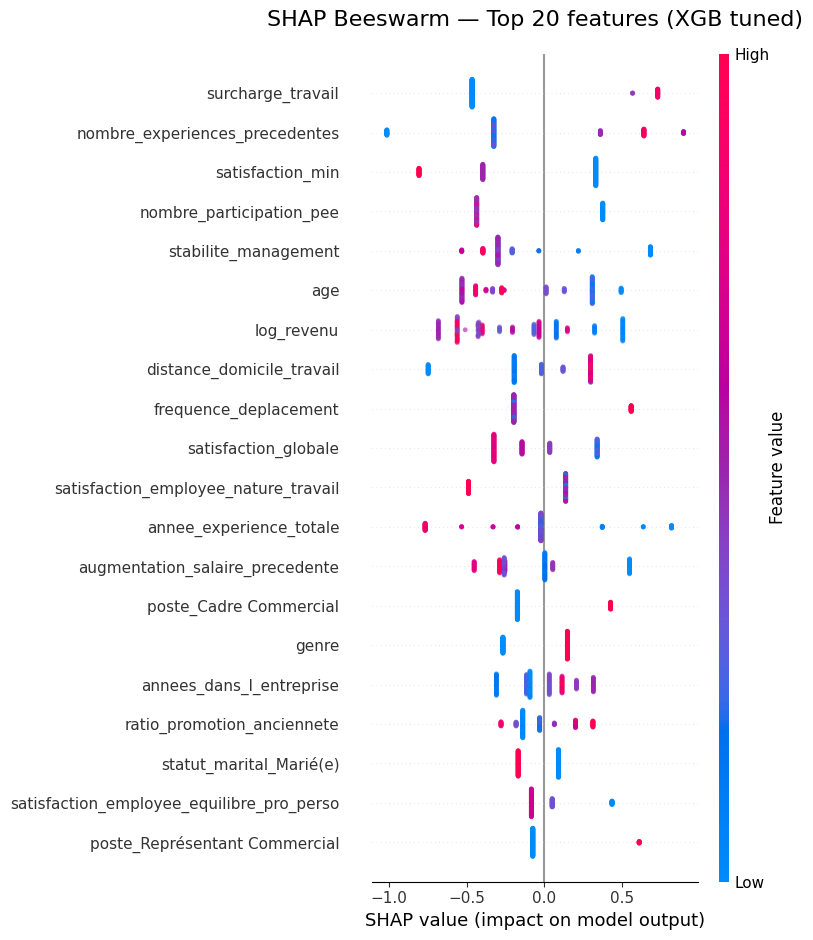

In [38]:
TOP_N = 20

plt.figure(figsize=(16, TOP_N * 0.9))

shap.plots.beeswarm(
    shap_values,
    max_display=TOP_N,
    alpha=0.6,
    s=12,
    group_remaining_features=False,
    show=False
)

plt.title("SHAP Beeswarm — Top 20 features (XGB tuned)",
          fontsize=16,
          pad=20)

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.tight_layout()
plt.show()


**Observation**

Le beeswarm montre que surcharge_travail est de loin le premier facteur expliquant les départs, suivi par nombre_participation_pee, satisfaction_min, log_revenu et ratio_promotion_anciennete. Les points rouges à droite indiquent que des niveaux élevés de surcharge augmentent fortement la probabilité de départ. À l’inverse, des valeurs élevées de satisfaction et de revenu déplacent les prédictions vers la classe “Reste”. Métier : le modèle identifie clairement une combinaison de pression opérationnelle, de fragilité émotionnelle et de reconnaissance insuffisante comme moteurs principaux de l’attrition.

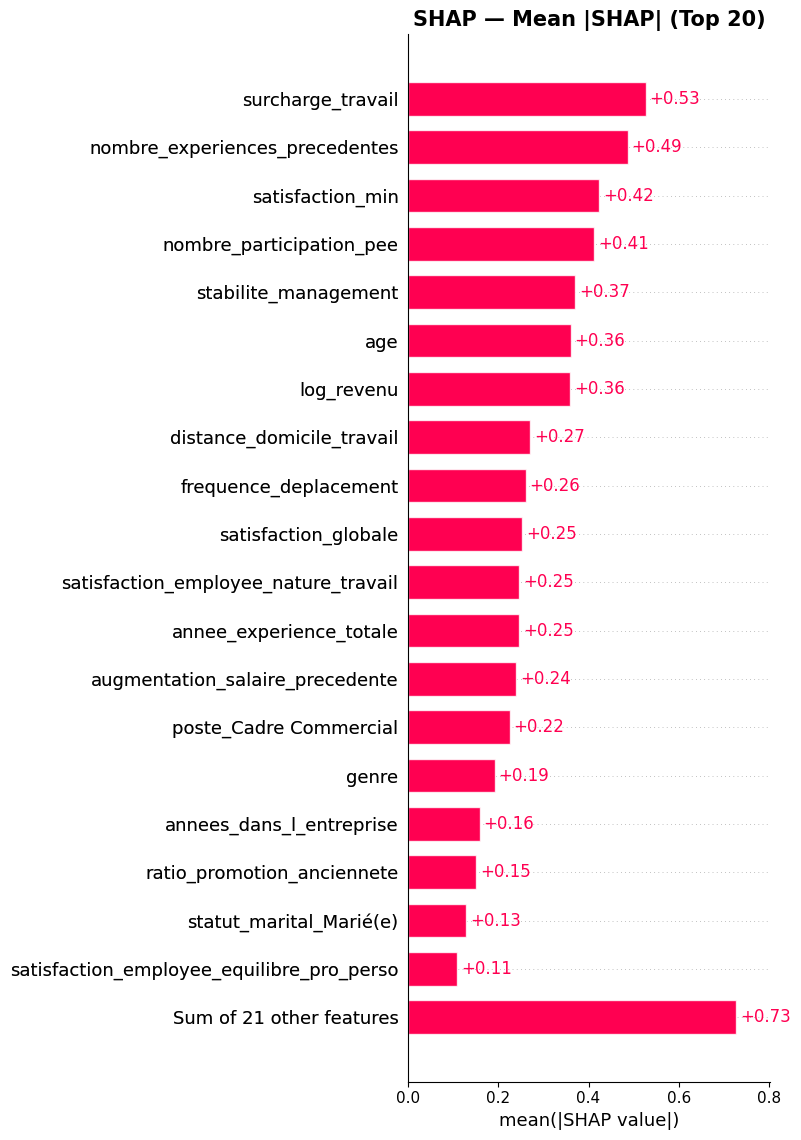

In [39]:
plt.figure(figsize=(10, TOP_N * 0.45 + 2))

shap.plots.bar(
    shap_values,
    max_display=TOP_N,
    show=False
)

plt.title("SHAP — Mean |SHAP| (Top 20)",
          fontsize=15,
          fontweight="bold")

plt.tight_layout()
plt.show()



**Observation**

Le barplot confirme l’ordre d’importance observé dans le beeswarm : surcharge de travail, participation au PEE, satisfaction minimale, revenu et dynamique de carrière dominent largement les autres variables. Les facteurs purement démographiques sont secondaires. Cela montre que les départs sont davantage liés aux conditions de travail et à l’engagement qu’au profil individuel. Pour les RH, cela oriente les actions vers l’organisation du travail, la reconnaissance et l’accompagnement plutôt que vers des critères personnels.

,Rang Permutation,Rang SHAP,Écart
feature,,,
surcharge_travail,1.0,1.0,0.0
nombre_experiences_precedentes,7.0,2.0,5.0
satisfaction_min,NaN,3.0,NaN
nombre_participation_pee,2.0,4.0,2.0
stabilite_management,3.0,5.0,2.0
age,NaN,6.0,NaN
log_revenu,4.0,7.0,3.0
distance_domicile_travail,11.0,8.0,3.0
frequence_deplacement,5.0,9.0,4.0


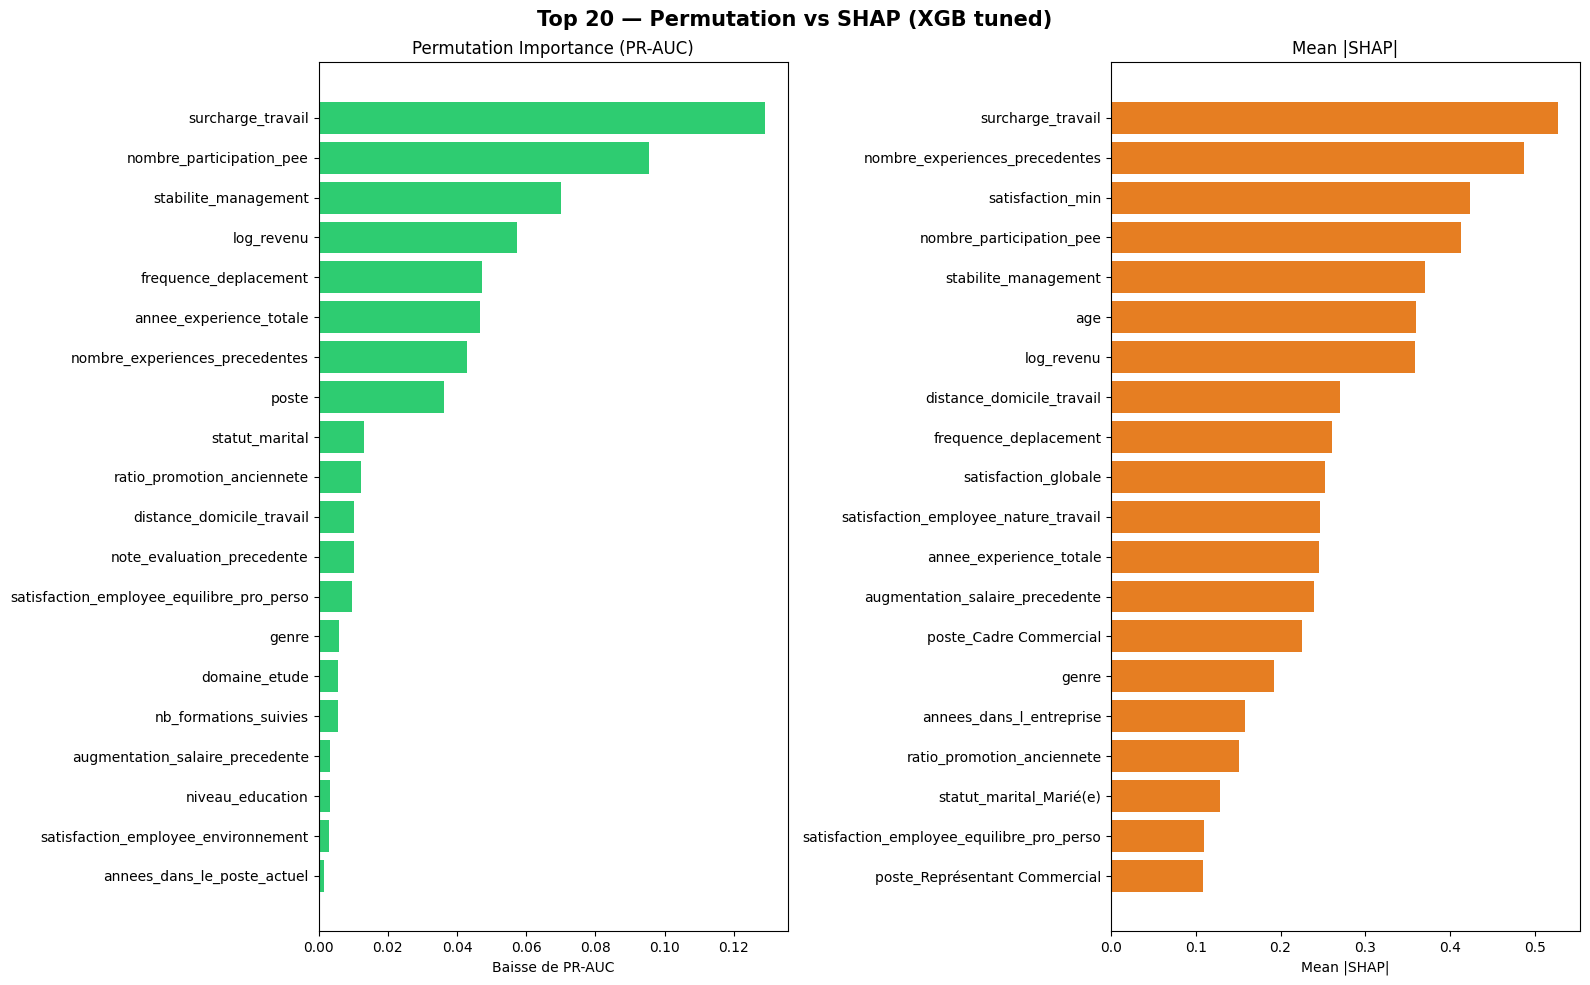

In [40]:
import numpy as np

# SHAP importance
shap_importance = pd.DataFrame({
    'feature': feature_names,
    'mean_shap': np.abs(shap_values.values).mean(axis=0)
}).sort_values('mean_shap', ascending=False)

# Permutation importance
perm_sorted = perm_df.sort_values('importance_mean', ascending=False)

# Top 20
shap_top = shap_importance.head(TOP_N)
perm_top = perm_sorted.head(TOP_N)

# Normaliser pour comparer les rangs
perm_ranks = perm_top.set_index('feature')['importance_mean'].rank(ascending=False)
shap_ranks = shap_top.set_index('feature')['mean_shap'].rank(ascending=False)

rank_comparison = pd.DataFrame({
    'Rang Permutation': perm_ranks,
    'Rang SHAP': shap_ranks,
    'Écart': (perm_ranks - shap_ranks).abs()
}).sort_values('Rang SHAP')

display(rank_comparison)

fig, axes = plt.subplots(1, 2, figsize=(16, TOP_N * 0.5))

axes[0].barh(perm_top['feature'], perm_top['importance_mean'], color='#2ecc71')
axes[0].invert_yaxis()
axes[0].set_title('Permutation Importance (PR-AUC)')
axes[0].set_xlabel('Baisse de PR-AUC')

axes[1].barh(shap_top['feature'], shap_top['mean_shap'], color='#e67e22')
axes[1].invert_yaxis()
axes[1].set_title('Mean |SHAP|')
axes[1].set_xlabel('Mean |SHAP|')

plt.suptitle('Top 20 — Permutation vs SHAP (XGB tuned)',
             fontsize=15,
             fontweight='bold')

plt.tight_layout()
plt.show()


**Observation**

Les deux méthodes placent surcharge_travail en première position, avec un rang identique. Plusieurs variables clés apparaissent dans les deux classements avec un faible écart de rang, ce qui confirme la robustesse des résultats. Cette convergence indique que les facteurs identifiés ne sont pas des artefacts du modèle. Métier : on peut s’appuyer avec confiance sur ces leviers pour définir des plans de prévention de l’attrition.

### 6.2.1 SHAP — Dependence plots

Le dependence plot montre, pour une feature donnée, la relation entre **sa valeur** (axe x) et **sa contribution SHAP** (axe y). Chaque point est un employé, coloré par la feature d'interaction la plus forte (choisie automatiquement par SHAP).

Ce type de graphique permet de :
- Visualiser la **forme de l'effet** (linéaire, seuil, plateau)
- Détecter des **interactions** entre features (gradient de couleur)
- Justifier le choix d'un modèle non-linéaire comme XGBoost

Deux features clés sont analysées : **surcharge_travail** (1er facteur d'attrition) et **satisfaction_min** (facteur de fragilité émotionnelle).


/home/rapha/ai-engineer/projet-4/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rapha/ai-engineer/projet-4/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


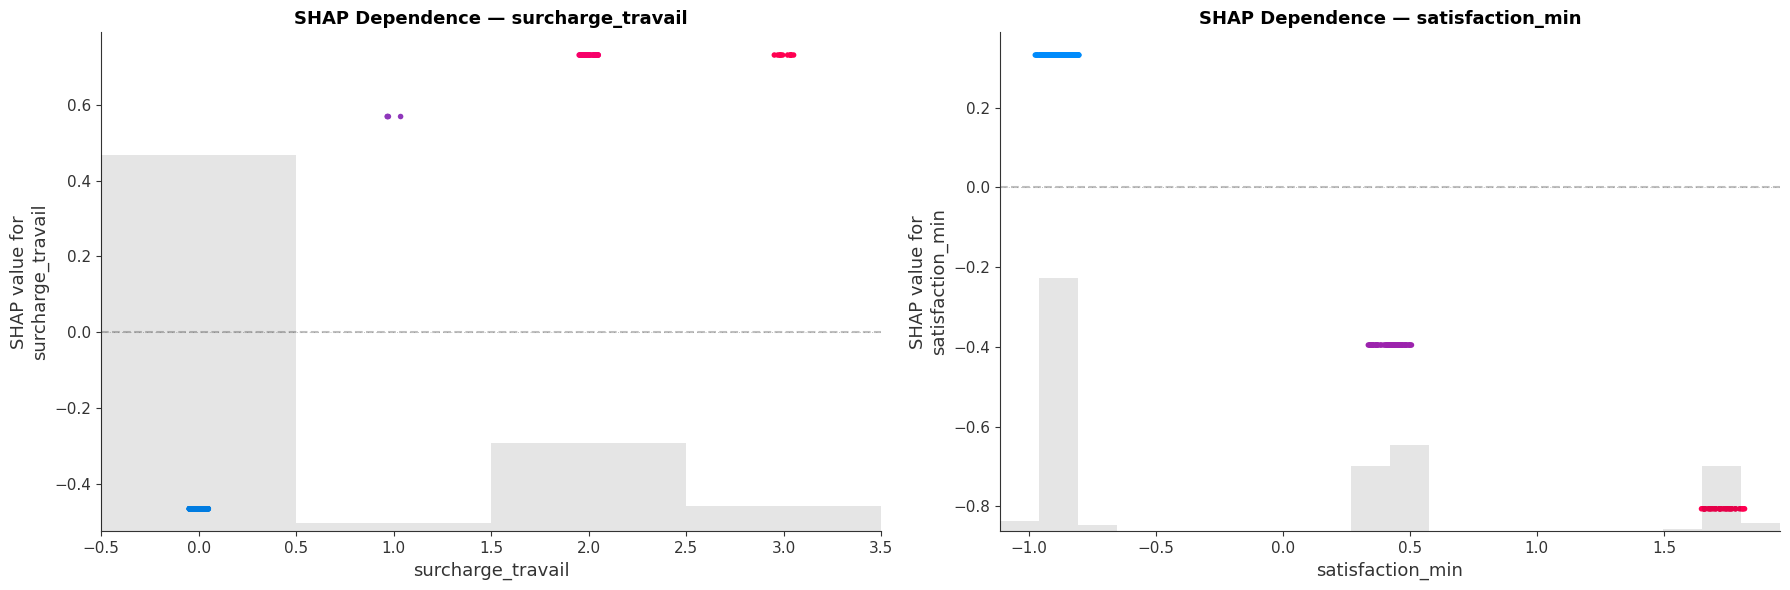

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Dependence plot — surcharge_travail
shap.plots.scatter(
    shap_values[:, "surcharge_travail"],
    color=shap_values,
    ax=axes[0],
    show=False
)
axes[0].set_title('SHAP Dependence — surcharge_travail', fontsize=13, fontweight='bold')
axes[0].axhline(y=0, color='grey', linestyle='--', alpha=0.5)

# Dependence plot — satisfaction_min
shap.plots.scatter(
    shap_values[:, "satisfaction_min"],
    color=shap_values,
    ax=axes[1],
    show=False
)
axes[1].set_title('SHAP Dependence — satisfaction_min', fontsize=13, fontweight='bold')
axes[1].axhline(y=0, color='grey', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


**Observation surcharge_travail**

Le graphique montre une augmentation nette de la contribution SHAP lorsque la surcharge de travail passe au-dessus d’un certain niveau. L’effet n’est pas linéaire : le risque de départ augmente fortement après un seuil, ce qui suggère un phénomène de rupture plutôt qu’une dégradation progressive. Métier : au-delà d’un certain volume ou intensité de charge, les employés basculent rapidement vers un risque élevé de départ, ce qui plaide pour une détection précoce des situations de surcharge.


**Observation satisfaction_min**

La relation est inverse : plus la satisfaction minimale est faible, plus la contribution au risque de départ est élevée. Les valeurs basses concentrent les SHAP positifs les plus importants. Cela traduit une vulnérabilité émotionnelle marquée chez certains employés. Métier : un niveau minimal de satisfaction agit comme un indicateur d’alerte, signalant des profils à risque qui peuvent bénéficier d’un accompagnement ciblé.

### 6.3 SHAP — Interprétation locale

L'interprétation locale permet d'expliquer la prédiction du modèle pour un employé individuel. Le **waterfall plot** décompose la prédiction en montrant la contribution de chaque feature, partant de la valeur de base (prédiction moyenne) jusqu'à la prédiction finale.

Trois profils sont sélectionnés pour illustrer des cas métier distincts :
- **Vrai positif** : un départ correctement détecté par le modèle
- **Faux négatif** : un départ que le modèle n'a pas anticipé
- **Vrai négatif** : un employé qui reste, correctement identifié


In [42]:
# Prédictions avec le seuil retenu
y_pred_final = (y_proba_test >= THRESHOLD).astype(int)

# Identifier les indices de chaque catégorie
tp_mask = (y_test == 1) & (y_pred_final == 1)  # Vrai positif
fn_mask = (y_test == 1) & (y_pred_final == 0)  # Faux négatif
tn_mask = (y_test == 0) & (y_pred_final == 0)  # Vrai négatif

# Sélectionner un exemple représentatif par catégorie
# VP : l'employé avec la proba la plus élevée (cas le plus "évident")
# FN : le départ manqué avec la proba la plus proche du seuil (cas limite)
# TN : un employé stable avec une proba basse
tp_idx = y_proba_test[tp_mask].argmax()  # position dans le masque
fn_idx = y_proba_test[fn_mask].argmax()  # FN le plus proche du seuil
tn_idx = y_proba_test[tn_mask].argmin()  # proba la plus basse

# Convertir en positions dans X_test
tp_pos = y_test.index[tp_mask][tp_idx]
fn_pos = y_test.index[fn_mask][fn_idx]
tn_pos = y_test.index[tn_mask][tn_idx]

# Positions dans le tableau shap_values (index 0-based du test set)
test_indices = y_test.index.tolist()
profiles = {
    'Vrai Positif (départ détecté)': test_indices.index(tp_pos),
    'Faux Négatif (départ manqué)': test_indices.index(fn_pos),
    'Vrai Négatif (reste, bien classé)': test_indices.index(tn_pos),
}

for label, idx in profiles.items():
    proba = y_proba_test[idx]
    real = int(y_test.iloc[idx])
    print(f"{label} — proba: {proba:.3f}, seuil: {THRESHOLD}, réel: {'Quitte' if real else 'Reste'}")


Vrai Positif (départ détecté) — proba: 0.990, seuil: 0.4, réel: Quitte
Faux Négatif (départ manqué) — proba: 0.374, seuil: 0.4, réel: Quitte
Vrai Négatif (reste, bien classé) — proba: 0.002, seuil: 0.4, réel: Reste


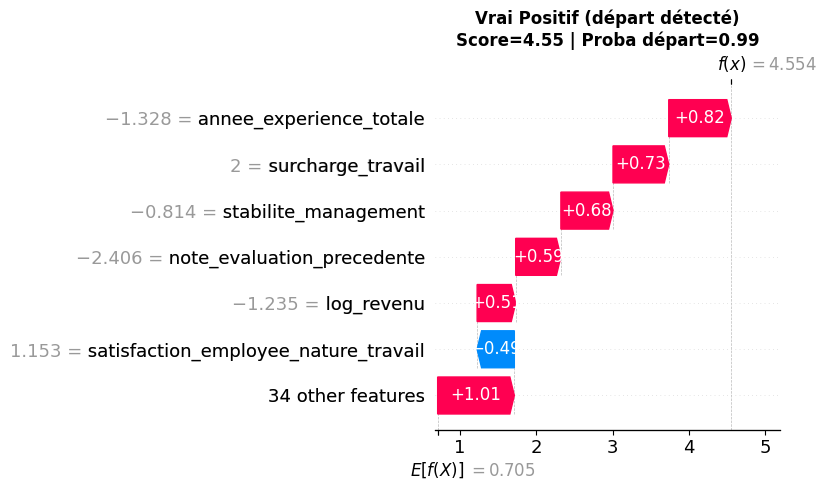

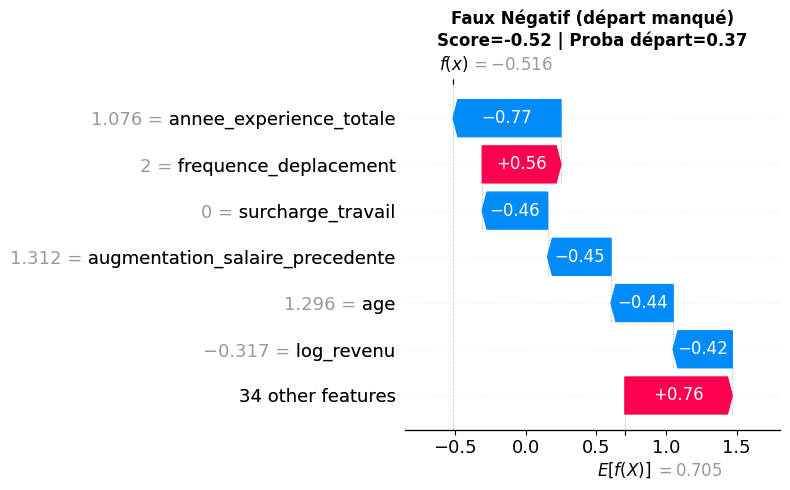

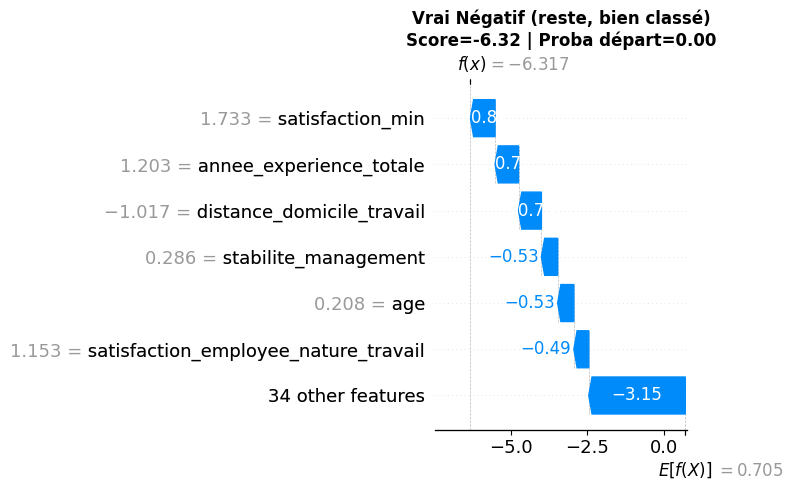

In [43]:
for label, idx in profiles.items():

    proba = y_proba_test[idx]

    # logit score = somme SHAP + base value
    fx = shap_values[idx].values.sum() + shap_values[idx].base_values

    plt.figure(figsize=(9, 4))

    shap.plots.waterfall(
        shap_values[idx],
        max_display=7,
        show=False
    )

    plt.title(
        f"{label}\nScore={fx:.2f} | Proba départ={proba:.2f}",
        fontsize=12,
        fontweight="bold"
    )

    plt.tight_layout()
    plt.show()

**Observation — Vrai positif (départ détecté)**

Le waterfall montre que la prédiction de départ est principalement portée par une forte surcharge de travail, une satisfaction faible et un ratio promotion/ancienneté défavorable, malgré quelques facteurs protecteurs. Le score final est très élevé (probabilité ≈ 0.99). Métier : ce profil correspond à un cas typique d’attrition liée à l’épuisement et au manque de perspectives, que le modèle identifie clairement.


**Observation - Faux négatif (départ manqué)**

Dans ce cas, certains signaux de risque sont présents, mais compensés par des facteurs positifs, ce qui maintient la probabilité juste en dessous du seuil (≈ 0.38 pour un seuil à 0.4). Le modèle manque ce départ car le profil est “limite”. Métier : cela illustre que certains départs restent difficiles à anticiper, notamment lorsque les signaux sont contradictoires, ce qui justifie un suivi humain complémentaire.


**Observation - Vrai négatif (reste, bien classé)**

Le graphique montre une accumulation de contributions négatives (satisfaction correcte, faible surcharge, stabilité), menant à une probabilité très basse de départ (≈ 0.01). Métier : ce profil correspond à un employé stable, pour lequel aucune action prioritaire n’est nécessaire, ce qui permet aux RH de concentrer leurs efforts ailleurs.

### 6.4 Causes principales d'attrition




Les analyses convergent vers quatre grands facteurs : surcharge de travail, faible satisfaction minimale, manque de reconnaissance financière (log_revenu, PEE) et dynamique de carrière défavorable (ratio promotion/ancienneté). Ces facteurs sont cohérents avec la littérature RH et expliquent la majorité des décisions du modèle. Métier : l’attrition est principalement organisationnelle et managériale, plus qu’individuelle.

### 6.5 Conclusion générale


